# A systematic evaluation of vision transformers for galaxy classification

## Data Import


## Without Augmentation

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import h5py
from tqdm import tqdm
import timm
import random
from torch.cuda.amp import GradScaler, autocast
from typing import List, Tuple


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# random seed
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

# Load HDF5 data 
file_path = "Galaxy10_DECals.h5"
with h5py.File(file_path, 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Train-validation-test split
galaxys = images.shape[0]
train_size = int(0.7 * galaxys)
valid_size = int(0.1 * galaxys)
indices = np.random.permutation(galaxys)
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]


# Dataset class

class GalaDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, indices: List[int], transforms) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transforms = transforms
        
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        idx = self.indices[index]
        image = self.images[idx]
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)
    
    def __len__(self) -> int:
        return len(self.indices)

    
# Data transformations

input_size = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.ToTensor()
])


# dataloaders

train_dataset = GalaDataset(images=images, labels=labels, indices=train_indices, transforms=train_transforms)
valid_dataset = GalaDataset(images=images, labels=labels, indices=valid_indices, transforms=valid_transforms)
test_dataset = GalaDataset(images=images, labels=labels, indices=test_indices, transforms=test_transforms)


# batch size

batch_size = 8  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## With Augmentation

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import h5py
from tqdm import tqdm
import timm
import random
from torch.cuda.amp import GradScaler, autocast
from typing import List, Tuple

# random seed
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

# Load HDF5 data  
file_path = "Galaxy10_DECals.h5"
with h5py.File(file_path, 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

galaxys = images.shape[0]
train_size = int(0.7 * galaxys)
valid_size = int(0.1 * galaxys)
indices = np.random.permutation(galaxys)
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]


# Dataset class

class GalaDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, indices: List[int], transforms) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transforms = transforms
        
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        idx = self.indices[index]
        image = self.images[idx]
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)
    
    def __len__(self) -> int:
        return len(self.indices)

    
# transformations

input_size = 224

train_transforms = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# dataloaders

train_dataset = GalaDataset(images=images, labels=labels, indices=train_indices, transforms=train_transforms)
valid_dataset = GalaDataset(images=images, labels=labels, indices=valid_indices, transforms=valid_transforms)
test_dataset = GalaDataset(images=images, labels=labels, indices=test_indices, transforms=test_transforms)


# batch size

batch_size = 8  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
len(train_dataset)

12415

In [15]:
len(valid_dataset)

1773

In [16]:
len(test_dataset)

3548

In [17]:
len(train_dataset)+len(test_dataset)+len(valid_dataset)

17736

# Visualizations

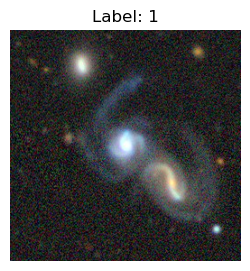

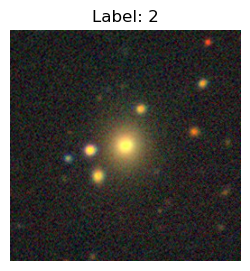

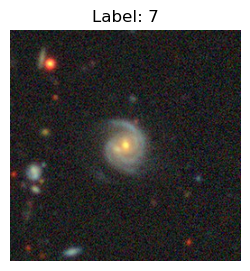

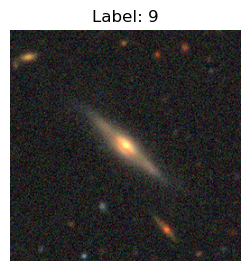

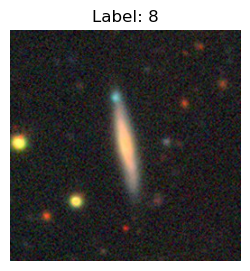

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
file_path = "Galaxy10_DECals.h5"

def visualize_single_image(file_path, index):
    with h5py.File(file_path, 'r') as f:
        image = f['images'][index]
        label = f['ans'][index]

        # Plot the image
        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

num_images_to_visualize = 5
with h5py.File(file_path, 'r') as f:
    total_size = len(f['images'])
indices = np.random.choice(total_size, num_images_to_visualize, replace=False)

for idx in indices:
    visualize_single_image(file_path, idx)


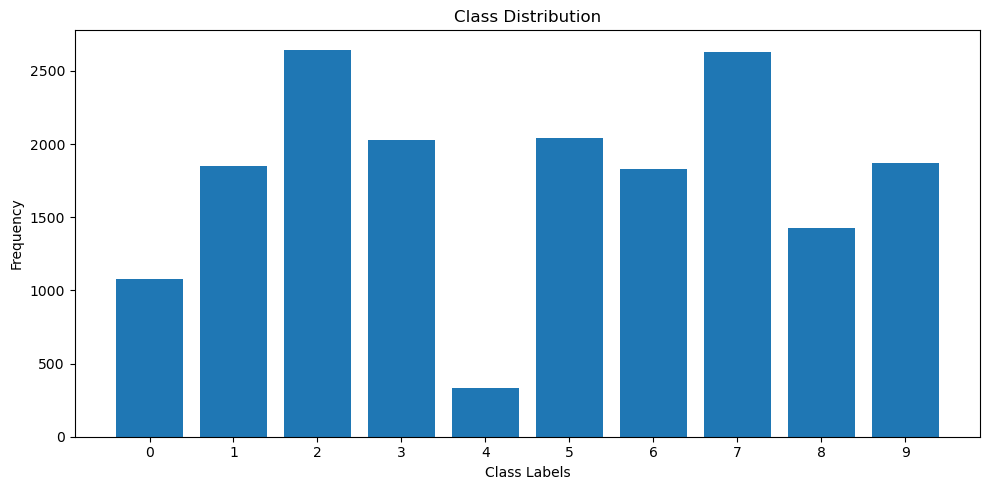

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(file_path):
    with h5py.File(file_path, 'r') as f:
        labels = f['ans'][:]
    
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts, tick_label=unique)
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title("Class Distribution")
    plt.tight_layout()
    plt.show()

plot_class_distribution(file_path)


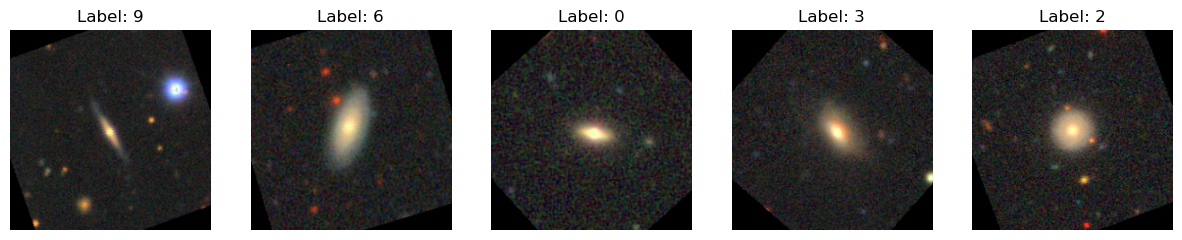

In [5]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def show_augmented_samples(data_loader, num_samples=5):
    images, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        image = image.numpy()
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.show()

show_augmented_samples(train_loader)


# Model Training

## Without Data Augmentation

# Swin Transformer Training - Without Data Augmentation

In [21]:
import timm
from tqdm import tqdm
from torchvision import models


model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [3]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Free up memory
torch.cuda.empty_cache()

num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:31<00:00,  1.34it/s]


Epoch 1/10
Train Loss: 0.7670, Train Acc: 0.7418
Val Loss: 0.5902, Val Acc: 0.8036


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:33<00:00,  1.33it/s]


Epoch 2/10
Train Loss: 0.4631, Train Acc: 0.8447
Val Loss: 0.5810, Val Acc: 0.7968


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:14<00:00,  1.19it/s]


Epoch 3/10
Train Loss: 0.3221, Train Acc: 0.8923
Val Loss: 0.5319, Val Acc: 0.8278


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:06<00:00,  1.21it/s]


Epoch 4/10
Train Loss: 0.2387, Train Acc: 0.9216
Val Loss: 0.5762, Val Acc: 0.8216


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:01<00:00,  1.23it/s]


Epoch 5/10
Train Loss: 0.1883, Train Acc: 0.9380
Val Loss: 0.5254, Val Acc: 0.8430


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:00<00:00,  1.23it/s]


Epoch 6/10
Train Loss: 0.1433, Train Acc: 0.9535
Val Loss: 0.6651, Val Acc: 0.8269


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:52<00:00,  1.26it/s]


Epoch 7/10
Train Loss: 0.1325, Train Acc: 0.9579
Val Loss: 0.6982, Val Acc: 0.8247


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:51<00:00,  1.26it/s]


Epoch 8/10
Train Loss: 0.1161, Train Acc: 0.9612
Val Loss: 0.6536, Val Acc: 0.8382


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:51<00:00,  1.26it/s]


Epoch 9/10
Train Loss: 0.0889, Train Acc: 0.9710
Val Loss: 0.7248, Val Acc: 0.8292


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:53<00:00,  1.26it/s]

Epoch 10/10
Train Loss: 0.0892, Train Acc: 0.9709
Val Loss: 0.7296, Val Acc: 0.8292


In [4]:
torch.save(model.state_dict(), "swin_transformer_galaxy10_decals.pth")

## With Time

In [3]:
import time
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import timm

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

In [4]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_model(model, va, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Free up memory
torch.cuda.empty_cache()

num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    
total_end_time = time.time()  
total_duration = total_end_time - start_time

print("Total Time to train: ",total_duration)


# Save trained model
torch.save(model.state_dict(), "swin_transformer_galaxy10_decals_withTime.pth")


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:12<00:00,  1.19it/s]


Epoch 1/10
Train Loss: 0.8720, Train Acc: 0.7020
Val Loss: 0.5338, Val Acc: 0.8145


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:39<00:00,  1.31it/s]


Epoch 2/10
Train Loss: 0.5655, Train Acc: 0.8069
Val Loss: 0.5477, Val Acc: 0.8227


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:37<00:00,  1.32it/s]


Epoch 3/10
Train Loss: 0.4969, Train Acc: 0.8313
Val Loss: 0.4904, Val Acc: 0.8337


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:31<00:00,  1.34it/s]


Epoch 4/10
Train Loss: 0.4666, Train Acc: 0.8458
Val Loss: 0.4947, Val Acc: 0.8427


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:42<00:00,  1.30it/s]


Epoch 5/10
Train Loss: 0.4431, Train Acc: 0.8495
Val Loss: 0.4677, Val Acc: 0.8405


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:40<00:00,  1.30it/s]


Epoch 6/10
Train Loss: 0.4122, Train Acc: 0.8580
Val Loss: 0.4724, Val Acc: 0.8467


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:33<00:00,  1.33it/s]


Epoch 7/10
Train Loss: 0.3919, Train Acc: 0.8669
Val Loss: 0.4652, Val Acc: 0.8512


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:45<00:00,  1.29it/s]


Epoch 8/10
Train Loss: 0.3738, Train Acc: 0.8727
Val Loss: 0.4862, Val Acc: 0.8388


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:32<00:00,  1.34it/s]


Epoch 9/10
Train Loss: 0.3576, Train Acc: 0.8744
Val Loss: 0.4662, Val Acc: 0.8441


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:42<00:00,  1.30it/s]


Epoch 10/10
Train Loss: 0.3550, Train Acc: 0.8771
Val Loss: 0.4502, Val Acc: 0.8515


NameError: name 'total_start_time' is not defined

In [11]:
from datetime import datetime

total_duration = total_end_time - start_time

print("Total Time to train: ", datetime.fromtimestamp(total_duration).strftime('%H:%M:%S'))

Total Time to train:  10:53:41


# Swin Transformer - With Data Augmentation

In [31]:
import time
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import timm
from datetime import datetime

# Swin Transformer 
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [6]:
import time
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt

# Swin Transformer
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

early_stopping = EarlyStopping(patience=5, min_delta=0.01, path='swin_best_model.pth')

def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Free up memory
torch.cuda.empty_cache()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 20
start_time = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if epoch >= 9:  
        torch.save(model.state_dict(), f"swin_model_epoch_{epoch+1}.pth")
        print(f"Model state saved at epoch {epoch+1}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

total_end_time = time.time()  
total_duration = total_end_time - start_time
print("Total Time to train: ", total_duration)


model.load_state_dict(torch.load('swin_best_model.pth'))


import csv

# Data headers
headers = ['epoch', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']

with open('training_progression.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    for i in range(len(train_losses)):
        writer.writerow([i+1, train_losses[i], val_losses[i], train_accuracies[i], val_accuracies[i]])



100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [04:10<00:00,  1.13s/it]


Epoch 1/20
Train Loss: 0.8621, Train Acc: 0.7031
Val Loss: 0.6377, Val Acc: 0.7908


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:46<00:00,  1.33it/s]


Epoch 2/20
Train Loss: 0.5744, Train Acc: 0.8071
Val Loss: 0.5806, Val Acc: 0.8105


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:46<00:00,  1.33it/s]


Epoch 3/20
Train Loss: 0.5012, Train Acc: 0.8280
Val Loss: 0.5014, Val Acc: 0.8257


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 4/20
Train Loss: 0.4647, Train Acc: 0.8394
Val Loss: 0.4807, Val Acc: 0.8291


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 5/20
Train Loss: 0.4360, Train Acc: 0.8530
Val Loss: 0.4220, Val Acc: 0.8522


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 6/20
Train Loss: 0.4102, Train Acc: 0.8595
Val Loss: 0.4558, Val Acc: 0.8511


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 7/20
Train Loss: 0.3994, Train Acc: 0.8631
Val Loss: 0.4696, Val Acc: 0.8364


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 8/20
Train Loss: 0.3733, Train Acc: 0.8757
Val Loss: 0.4525, Val Acc: 0.8488


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 9/20
Train Loss: 0.3601, Train Acc: 0.8776
Val Loss: 0.4311, Val Acc: 0.8522


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:45<00:00,  1.34it/s]


Epoch 10/20
Train Loss: 0.3435, Train Acc: 0.8826
Val Loss: 0.4287, Val Acc: 0.8550
Model state saved at epoch 10
Early stopping
Total Time to train:  36297.402589559555


### Total Duration of Training - Swin Transformer

In [2]:
print("Total Time to train: ", datetime.fromtimestamp(36297.402589559555).strftime('%H:%M:%S'))

Total Time to train:  10:04:57


# ViT Base Model! Without Data Augmentation

In [4]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import StepLR
# Hyperparameters
LR = 5e-5
STEP_SIZE = 5
GAMMA = 0.1
MAX_EPOCH = 50
class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).to(device)
model_name = "ViT_without_augment"

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(in_features=768, out_features=10, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

model.to(device)

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Number of trainable parameters: 85806346


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [5]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    best_model_weights = deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_valid_acc = 0.0
    best_epoch = -1

    history_dic = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train
        model.train()
        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            _, pred_classes = torch.max(outputs.logits.detach(), dim=1)

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                _, pred_classes = torch.max(outputs.logits.detach(), dim=1)
                loss = criterion(outputs.logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

        # metrics
        train_loss = epoch_train_cum_loss / len(train_loader.dataset)
        train_acc = epoch_train_cum_corrects / len(train_loader.dataset)
        valid_loss = epoch_valid_cum_loss / len(valid_loader.dataset)
        valid_acc = epoch_valid_cum_corrects / len(valid_loader.dataset)

        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if best acc
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join('./', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        if (epoch + 1) % print_every == 0:
            if epoch == (best_epoch - 1):
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s\t<--")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s")

        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break
        
        scheduler.step()

    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training accuracy = {best_train_acc:.4f} and validation accuracy = {best_valid_acc:.4f}")

    return model, history_dic


trained_model, training_history = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler)


Epoch 1/50	Train loss: 0.8011	Train acc: 0.7260	Valid loss: 0.6791	Valid acc: 0.7659	Time: 19m 32s	<--
Epoch 2/50	Train loss: 0.5336	Train acc: 0.8189	Valid loss: 0.5472	Valid acc: 0.8082	Time: 34m 39s	<--
Epoch 3/50	Train loss: 0.4485	Train acc: 0.8461	Valid loss: 0.5123	Valid acc: 0.8319	Time: 33m 41s	<--
Epoch 4/50	Train loss: 0.3867	Train acc: 0.8665	Valid loss: 0.5012	Valid acc: 0.8409	Time: 17m 44s	<--
Epoch 5/50	Train loss: 0.3430	Train acc: 0.8828	Valid loss: 0.5586	Valid acc: 0.8161	Time: 17m 45s
Epoch 6/50	Train loss: 0.1790	Train acc: 0.9397	Valid loss: 0.4600	Valid acc: 0.8545	Time: 18m 10s	<--
Epoch 7/50	Train loss: 0.1451	Train acc: 0.9538	Valid loss: 0.4612	Valid acc: 0.8573	Time: 18m 4s	<--
Epoch 8/50	Train loss: 0.1189	Train acc: 0.9608	Valid loss: 0.4750	Valid acc: 0.8500	Time: 18m 1s
Epoch 9/50	Train loss: 0.1046	Train acc: 0.9672	Valid loss: 0.4793	Valid acc: 0.8550	Time: 17m 52s
Epoch 10/50	Train loss: 0.0900	Train acc: 0.9707	Valid loss: 0.5159	Valid acc: 0.8517	T

In [6]:
# Save best weights
torch.save(model.state_dict(), 'Vit_Base_Without_Augment' + '.pth')
torch.save(model.state_dict(), os.path.join('./', model_name + '.pth'))

In [1]:
df = pd.DataFrame(training_history)

csv_path = "./Vit_training_history_without_augment.csv"
df.to_csv(csv_path, index=False)

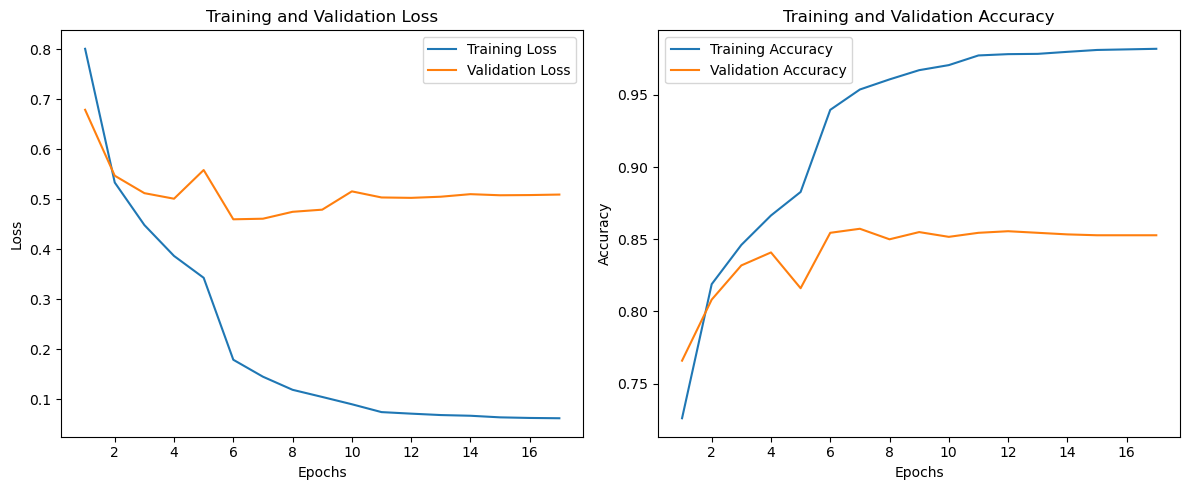

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = 'Vit_training_history_without_augment.csv'  # Update with your file path if necessary
history = pd.read_csv(csv_path)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train_loss'], label='Training Loss')
plt.plot(history['Epoch'], history['Valid_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train_acc'], label='Training Accuracy')
plt.plot(history['Epoch'], history['Valid_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# ViT Base Model! -  Finetuned! - With Augment

In [3]:
from linformer import Linformer
from torchvision.models import resnet50
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import h5py
from tqdm import tqdm
import random
from linformer import Linformer
from torchvision.models import resnet50
from torch.cuda.amp import GradScaler, autocast
from typing import List, Tuple
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# Hyperparameters
LR = 5e-5
STEP_SIZE = 5
GAMMA = 0.1
MAX_EPOCH = 50
class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).to(device)
model_name = "gz2_hug_vit_010822B"

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(in_features=768, out_features=10, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

model.to(device)

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Number of trainable parameters: 85806346


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [11]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import StepLR



criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    best_model_weights = deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_valid_acc = 0.0
    best_epoch = -1

    history_dic = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train
        model.train()
        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            _, pred_classes = torch.max(outputs.logits.detach(), dim=1)

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                _, pred_classes = torch.max(outputs.logits.detach(), dim=1)
                loss = criterion(outputs.logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

        train_loss = epoch_train_cum_loss / len(train_loader.dataset)
        train_acc = epoch_train_cum_corrects / len(train_loader.dataset)
        valid_loss = epoch_valid_cum_loss / len(valid_loader.dataset)
        valid_acc = epoch_valid_cum_corrects / len(valid_loader.dataset)

        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join('./', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        if (epoch + 1) % print_every == 0:
            if epoch == (best_epoch - 1):
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s\t<--")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s")

        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break
        
        scheduler.step()

    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training accuracy = {best_train_acc:.4f} and validation accuracy = {best_valid_acc:.4f}")

    return model, history_dic


trained_model, training_history = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler)


Epoch 1/200	Train loss: 0.7762	Train acc: 0.7331	Valid loss: 0.6246	Valid acc: 0.7940	Time: 18m 45s	<--
Epoch 2/200	Train loss: 0.5556	Train acc: 0.8135	Valid loss: 0.5113	Valid acc: 0.8233	Time: 18m 44s	<--
Epoch 3/200	Train loss: 0.4948	Train acc: 0.8284	Valid loss: 0.5426	Valid acc: 0.8196	Time: 18m 46s
Epoch 4/200	Train loss: 0.4518	Train acc: 0.8432	Valid loss: 0.5075	Valid acc: 0.8272	Time: 18m 47s	<--
Epoch 5/200	Train loss: 0.4245	Train acc: 0.8510	Valid loss: 0.5282	Valid acc: 0.8182	Time: 18m 45s
Epoch 6/200	Train loss: 0.2976	Train acc: 0.8981	Valid loss: 0.4187	Valid acc: 0.8582	Time: 18m 47s	<--
Epoch 7/200	Train loss: 0.2676	Train acc: 0.9066	Valid loss: 0.4100	Valid acc: 0.8636	Time: 18m 46s	<--
Epoch 8/200	Train loss: 0.2448	Train acc: 0.9141	Valid loss: 0.4151	Valid acc: 0.8622	Time: 18m 48s
Epoch 9/200	Train loss: 0.2384	Train acc: 0.9153	Valid loss: 0.4131	Valid acc: 0.8610	Time: 18m 48s
Epoch 10/200	Train loss: 0.2247	Train acc: 0.9221	Valid loss: 0.4146	Valid acc: 

In [12]:
## Save the best weights
torch.save(model.state_dict(), 'Decals_ViT_Base_finetuned_final' + '.pth')
torch.save(model.state_dict(), os.path.join('./', model_name + '.pth'))

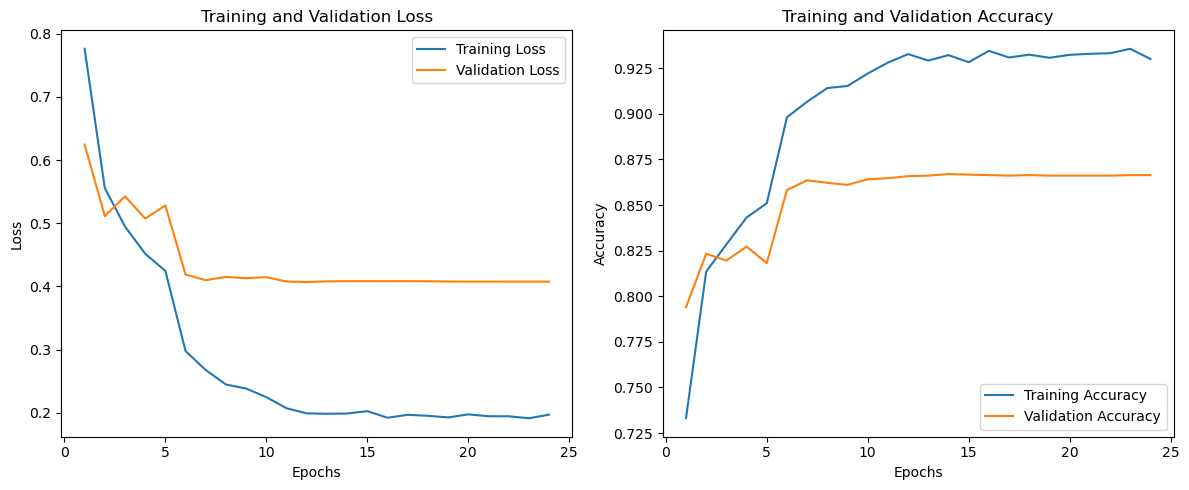

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history_dic):
    epochs = range(1, len(history_dic['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dic['train_loss'], label='Training Loss')
    plt.plot(epochs, history_dic['valid_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dic['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history_dic['valid_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(training_history)


# DeiT - Data Efficient Image Transformer - Without Augment

In [2]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [3]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import StepLR


model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

early_stopping = EarlyStopping(patience=5, min_delta=0.01, path='deit_best_without_augment.pth')

def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

torch.cuda.empty_cache()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 20
start_time = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

total_end_time = time.time()  
total_duration = total_end_time - start_time

print("Total Time to train: ", total_duration)

print("Total Time to train in Hours: ", datetime.fromtimestamp(total_duration).strftime('%H:%M:%S'))

  0%|                                                                                         | 0/1552 [00:00<?, ?it/s]C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:42<00:00,  1.37it/s]


Epoch 1/20
Train Loss: 0.8631, Train Acc: 0.7040
Val Loss: 0.6483, Val Acc: 0.7783


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 2/20
Train Loss: 0.5961, Train Acc: 0.7994
Val Loss: 0.5869, Val Acc: 0.8077


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 3/20
Train Loss: 0.4987, Train Acc: 0.8314
Val Loss: 0.5679, Val Acc: 0.8065


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 4/20
Train Loss: 0.4411, Train Acc: 0.8458
Val Loss: 0.5833, Val Acc: 0.8077


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 5/20
Train Loss: 0.3901, Train Acc: 0.8660
Val Loss: 0.5443, Val Acc: 0.8336


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 6/20
Train Loss: 0.3355, Train Acc: 0.8860
Val Loss: 0.5546, Val Acc: 0.8218


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 7/20
Train Loss: 0.3130, Train Acc: 0.8901
Val Loss: 0.5430, Val Acc: 0.8257


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 8/20
Train Loss: 0.2675, Train Acc: 0.9066
Val Loss: 0.6163, Val Acc: 0.8127


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:39<00:00,  1.39it/s]


Epoch 9/20
Train Loss: 0.2381, Train Acc: 0.9188
Val Loss: 0.6472, Val Acc: 0.8105


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.37it/s]


Epoch 10/20
Train Loss: 0.2110, Train Acc: 0.9288
Val Loss: 0.7219, Val Acc: 0.8116
Early stopping
Total Time to train:  34971.63448596001


NameError: name 'datetime' is not defined

In [7]:
from datetime import datetime
print("Total Time to train in Hours: ", datetime.fromtimestamp(total_duration).strftime('%H:%M:%S'))

Total Time to train in Hours:  09:42:51


# DeiT - Data Efficient Image Transformer - With Augmentation

In [6]:
model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_model(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Free up memory
torch.cuda.empty_cache()

num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "deit_galaxy10.pth")

  0%|                                                                                         | 0/1552 [00:00<?, ?it/s]C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [04:21<00:00,  1.18s/it]


Epoch 1/10
Train Loss: 0.8314, Train Acc: 0.7115
Val Loss: 0.6498, Val Acc: 0.7761


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [04:05<00:00,  1.10s/it]


Epoch 2/10
Train Loss: 0.5887, Train Acc: 0.8022
Val Loss: 0.5924, Val Acc: 0.7902


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [03:52<00:00,  1.05s/it]


Epoch 3/10
Train Loss: 0.5192, Train Acc: 0.8234
Val Loss: 0.5449, Val Acc: 0.8173


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:42<00:00,  1.36it/s]


Epoch 4/10
Train Loss: 0.4843, Train Acc: 0.8300
Val Loss: 0.4732, Val Acc: 0.8347


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 5/10
Train Loss: 0.4452, Train Acc: 0.8478
Val Loss: 0.5617, Val Acc: 0.8116


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.37it/s]


Epoch 6/10
Train Loss: 0.4308, Train Acc: 0.8478
Val Loss: 0.5057, Val Acc: 0.8240


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 7/10
Train Loss: 0.4030, Train Acc: 0.8597
Val Loss: 0.5201, Val Acc: 0.8201


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:40<00:00,  1.38it/s]


Epoch 8/10
Train Loss: 0.3962, Train Acc: 0.8602
Val Loss: 0.5185, Val Acc: 0.8206


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:43<00:00,  1.35it/s]


Epoch 9/10
Train Loss: 0.3625, Train Acc: 0.8712
Val Loss: 0.4946, Val Acc: 0.8404


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 10/10
Train Loss: 0.3484, Train Acc: 0.8773
Val Loss: 0.4652, Val Acc: 0.8432


## With Early Stopping

In [11]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import StepLR


model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

early_stopping = EarlyStopping(patience=5, min_delta=0.01, path='deit_best_model.pth')

def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Free up memory
torch.cuda.empty_cache()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training with early stopping
num_epochs = 20
start_time = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

total_end_time = time.time()  
total_duration = total_end_time - start_time

print("Total Time to train: ", total_duration)

print("Total Time to train in Hours: ", datetime.fromtimestamp(total_duration).strftime('%H:%M:%S'))

  0%|                                                                                         | 0/1552 [00:00<?, ?it/s]C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:43<00:00,  1.36it/s]


Epoch 1/20
Train Loss: 0.8290, Train Acc: 0.7094
Val Loss: 0.6219, Val Acc: 0.7924


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:44<00:00,  1.35it/s]


Epoch 2/20
Train Loss: 0.5753, Train Acc: 0.8016
Val Loss: 0.6411, Val Acc: 0.7913


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 3/20
Train Loss: 0.5216, Train Acc: 0.8202
Val Loss: 0.5187, Val Acc: 0.8246


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 4/20
Train Loss: 0.4747, Train Acc: 0.8344
Val Loss: 0.5423, Val Acc: 0.8144


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 5/20
Train Loss: 0.4462, Train Acc: 0.8481
Val Loss: 0.4705, Val Acc: 0.8308


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 6/20
Train Loss: 0.4269, Train Acc: 0.8518
Val Loss: 0.5090, Val Acc: 0.8331


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 7/20
Train Loss: 0.4035, Train Acc: 0.8611
Val Loss: 0.4884, Val Acc: 0.8364


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 8/20
Train Loss: 0.3754, Train Acc: 0.8686
Val Loss: 0.4834, Val Acc: 0.8359


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:41<00:00,  1.38it/s]


Epoch 9/20
Train Loss: 0.3618, Train Acc: 0.8697
Val Loss: 0.5403, Val Acc: 0.8150


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [03:04<00:00,  1.21it/s]

Epoch 10/20
Train Loss: 0.3406, Train Acc: 0.8817
Val Loss: 0.5913, Val Acc: 0.8150
Early stopping
Total Time to train:  35355.44872546196
Total Time to train in Hours:  09:49:15


# ResNet50 - With Data Augmentation

In [3]:
import time
import os
import pandas as pd
from copy import deepcopy
import torch.optim as optim
from torch.optim import lr_scheduler


In [4]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

# Hyperparameters
LR = 1e-5
STEP_SIZE = 10
MAX_EPOCH = 50
NUM_OF_CLASSES = 10  

model_name = "gz2_resnet50_A"

model = models.resnet50(pretrained=True)

# Change last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)
print(model.fc)  # Print the modified last layer

print("============")
print("Training")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("============")



# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

scheduler = StepLR(optimizer, step_size=STEP_SIZE)

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=10, bias=True)
Training
Number of trainable parameters: 23528522


### Now Training!

In [5]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=5):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    best_model_weights = deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_valid_acc = 0.0
    best_epoch = -1

    history_dic = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train
        model.train()
        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, pred_classes = torch.max(outputs.detach(), dim=1)

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                _, pred_classes = torch.max(outputs.detach(), dim=1)
                loss = criterion(outputs, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

        # metrics
        train_loss = epoch_train_cum_loss / len(train_loader.dataset)
        train_acc = epoch_train_cum_corrects / len(train_loader.dataset)
        valid_loss = epoch_valid_cum_loss / len(test_loader.dataset)
        valid_acc = epoch_valid_cum_corrects / len(test_loader.dataset)

        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # Check if best acc 
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join('./', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        if (epoch + 1) % print_every == 0:
            if epoch == (best_epoch - 1):
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s\t<--")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s")

        # Early stopping
        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break
        
        scheduler.step()

    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training accuracy = {best_train_acc:.4f} and validation accuracy = {best_valid_acc:.4f}")

    return model, history_dic
resnet_start_time = time.time()

trained_model, training_history = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler)
resnet_end_time = time.time()

Epoch 1/50	Train loss: 1.9526	Train acc: 0.2723	Valid loss: 1.7903	Valid acc: 0.3216	Time: 6m 17s	<--
Epoch 2/50	Train loss: 1.6283	Train acc: 0.3822	Valid loss: 1.5172	Valid acc: 0.4045	Time: 11m 22s	<--
Epoch 3/50	Train loss: 1.4251	Train acc: 0.4696	Valid loss: 1.3431	Valid acc: 0.5166	Time: 5m 50s	<--
Epoch 4/50	Train loss: 1.2432	Train acc: 0.5523	Valid loss: 1.0777	Valid acc: 0.6212	Time: 5m 29s	<--
Epoch 5/50	Train loss: 1.0955	Train acc: 0.6132	Valid loss: 1.1116	Valid acc: 0.6246	Time: 6m 15s	<--
Epoch 6/50	Train loss: 0.9912	Train acc: 0.6553	Valid loss: 0.8774	Valid acc: 0.6936	Time: 6m 47s	<--
Epoch 7/50	Train loss: 0.9020	Train acc: 0.6888	Valid loss: 0.8257	Valid acc: 0.7162	Time: 7m 22s	<--
Epoch 8/50	Train loss: 0.8431	Train acc: 0.7104	Valid loss: 0.7857	Valid acc: 0.7353	Time: 9m 1s	<--
Epoch 9/50	Train loss: 0.7988	Train acc: 0.7265	Valid loss: 0.7438	Valid acc: 0.7492	Time: 8m 2s	<--
Epoch 10/50	Train loss: 0.7542	Train acc: 0.7392	Valid loss: 0.8339	Valid acc: 0.72

In [6]:
resnet_total_time = resnet_end_time - resnet_start_time
print("Total Time to train ResNet50 is: ", resnet_total_time)

Total Time to train ResNet50 is:  8110.67359495163


In [1]:
from datetime import datetime
print("Total Time to train in Hours: ", datetime.fromtimestamp(8110.67359495163).strftime('%H:%M:%S'))

Total Time to train in Hours:  02:15:10


In [7]:
import pandas as pd
# history to dataframe
history_df = pd.DataFrame(training_history)

history_df.to_csv(model_name + '_history.csv')
history_df.to_csv(os.path.join('./', model_name + '_history.csv'))
     

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv("gz2_resnet50_A_history.csv")
history_df

Unnamed: 0  train_loss  train_acc  valid_loss  valid_acc       lr
0            0    1.952641   0.272332    1.790292   0.321590  0.00100
1            1    1.628305   0.382199    1.517172   0.404453  0.00100
2            2    1.425054   0.469593    1.343124   0.516629  0.00100
3            3    1.243244   0.552316    1.077693   0.621195  0.00100
4            4    1.095513   0.613210    1.111575   0.624577  0.00100
5            5    0.991199   0.655336    0.877399   0.693630  0.00100
6            6    0.902037   0.688764    0.825746   0.716178  0.00100
7            7    0.843125   0.710431    0.785682   0.735344  0.00100
8            8    0.798814   0.726540    0.743751   0.749154  0.00100
9            9    0.754185   0.739186    0.833869   0.724634  0.00100
10          10    0.618244   0.785663    0.580406   0.807497  0.00010
11          11    0.585005   0.796375    0.562192   0.813980  0.00010
12          12    0.557028   0.809746    0.579952   0.810316  0.00010
13          13    0.557177   0.809182    0.553826   0.819617  0.00010
14          14    0.547537   0.808619    0.544124   0.820462  0.00010
15          15    0.531321   0.813613    0.544907   0.826099  0.00010
16          16    0.528590   0.813049    0.530371   0.831454  0.00010
17          17    0.523432   0.818204    0.545756   0.820744  0.00010
18          18    0.516440   0.818365    0.523079   0.828354  0.00010
19          19    0.514209   0.820298    0.527812   0.825254  0.00010
20          20    0.497060   0.829642    0.523095   0.828072  0.00001
21          21    0.489709   0.827708    0.520721   0.828636  0.00001

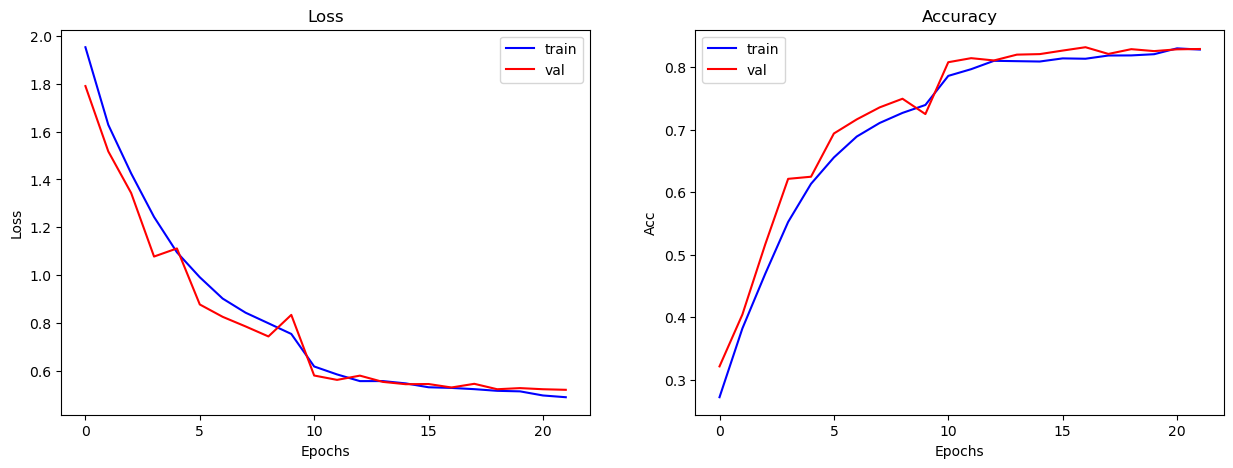

In [23]:
epochs = len(history_df['valid_acc'])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_df['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_df['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_df['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_df['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()

plt.show()


# ResNet50 - Without Augmentation

In [15]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

LR = 1e-5
STEP_SIZE = 10
MAX_EPOCH = 50
NUM_OF_CLASSES = 10  # Make sure this matches the number of classes in your dataset

model_name = "resnet50_without_augment"

model = models.resnet50(pretrained=True)

# Change last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)
print(model.fc)  # Print the modified last layer

print("============")
print("Training")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("============")

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters())

# Scheduler
scheduler = StepLR(optimizer, step_size=STEP_SIZE)

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=10, bias=True)
Training
Number of trainable parameters: 23528522


In [16]:
# Training function
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=5):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # Cache the best model
    best_model_weights = deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_valid_acc = 0.0
    best_epoch = -1

    history_dic = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train
        model.train()
        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, pred_classes = torch.max(outputs.detach(), dim=1)

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                _, pred_classes = torch.max(outputs.detach(), dim=1)
                loss = criterion(outputs, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

        # metrics
        train_loss = epoch_train_cum_loss / len(train_loader.dataset)
        train_acc = epoch_train_cum_corrects / len(train_loader.dataset)
        valid_loss = epoch_valid_cum_loss / len(test_loader.dataset)
        valid_acc = epoch_valid_cum_corrects / len(test_loader.dataset)

        # Update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # Check if best acc 
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join('./', model_name + "_new_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        if (epoch + 1) % print_every == 0:
            if epoch == (best_epoch - 1):
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s\t<--")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s")

        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break
        
        scheduler.step()

    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training accuracy = {best_train_acc:.4f} and validation accuracy = {best_valid_acc:.4f}")

    return model, history_dic
resnet_start_time = time.time()

trained_model, training_history = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler)
resnet_end_time = time.time()

Epoch 1/50	Train loss: 1.9073	Train acc: 0.3017	Valid loss: 1.6165	Valid acc: 0.3994	Time: 5m 8s	<--
Epoch 2/50	Train loss: 1.5419	Train acc: 0.4250	Valid loss: 1.3271	Valid acc: 0.5220	Time: 5m 10s	<--
Epoch 3/50	Train loss: 1.3432	Train acc: 0.5088	Valid loss: 1.1949	Valid acc: 0.5817	Time: 5m 16s	<--
Epoch 4/50	Train loss: 1.1725	Train acc: 0.5791	Valid loss: 1.0308	Valid acc: 0.6395	Time: 5m 18s	<--
Epoch 5/50	Train loss: 1.0382	Train acc: 0.6369	Valid loss: 0.9585	Valid acc: 0.6640	Time: 5m 18s	<--
Epoch 6/50	Train loss: 0.9431	Train acc: 0.6727	Valid loss: 0.8475	Valid acc: 0.7094	Time: 5m 19s	<--
Epoch 7/50	Train loss: 0.8737	Train acc: 0.6935	Valid loss: 0.9035	Valid acc: 0.6832	Time: 5m 18s
Epoch 8/50	Train loss: 0.8100	Train acc: 0.7182	Valid loss: 0.8091	Valid acc: 0.7196	Time: 5m 18s	<--
Epoch 9/50	Train loss: 0.7542	Train acc: 0.7418	Valid loss: 0.6701	Valid acc: 0.7765	Time: 5m 22s	<--
Epoch 10/50	Train loss: 0.7273	Train acc: 0.7501	Valid loss: 0.8666	Valid acc: 0.7094	T

In [6]:
import pandas as pd
## Convert history to dataframe
history_df = pd.DataFrame(training_history)

## Save the history
history_df.to_csv(model_name + '_history.csv')
history_df.to_csv(os.path.join('./', model_name + '_history.csv'))
     

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv("ResNet50_finetuned_history.csv")
history_df

Unnamed: 0  train_loss  train_acc  valid_loss  valid_acc        lr
0            0    1.247717   0.589287    0.688870   0.777057  0.000010
1            1    0.774358   0.751832    0.575324   0.811725  0.000010
2            2    0.635194   0.794120    0.566693   0.813980  0.000010
3            3    0.536827   0.828917    0.582211   0.814825  0.000010
4            4    0.464044   0.851551    0.547224   0.818771  0.000010
5            5    0.405271   0.870399    0.572821   0.820180  0.000010
6            6    0.367258   0.884172    0.562000   0.822153  0.000010
7            7    0.314448   0.901490    0.566769   0.833145  0.000010
8            8    0.283810   0.910431    0.604641   0.815389  0.000010
9            9    0.249208   0.918325    0.644501   0.821871  0.000010
10          10    0.181028   0.943536    0.611238   0.826099  0.000001
11          11    0.160848   0.951188    0.604645   0.833145  0.000001
12          12    0.148011   0.956101    0.605612   0.832300  0.000001

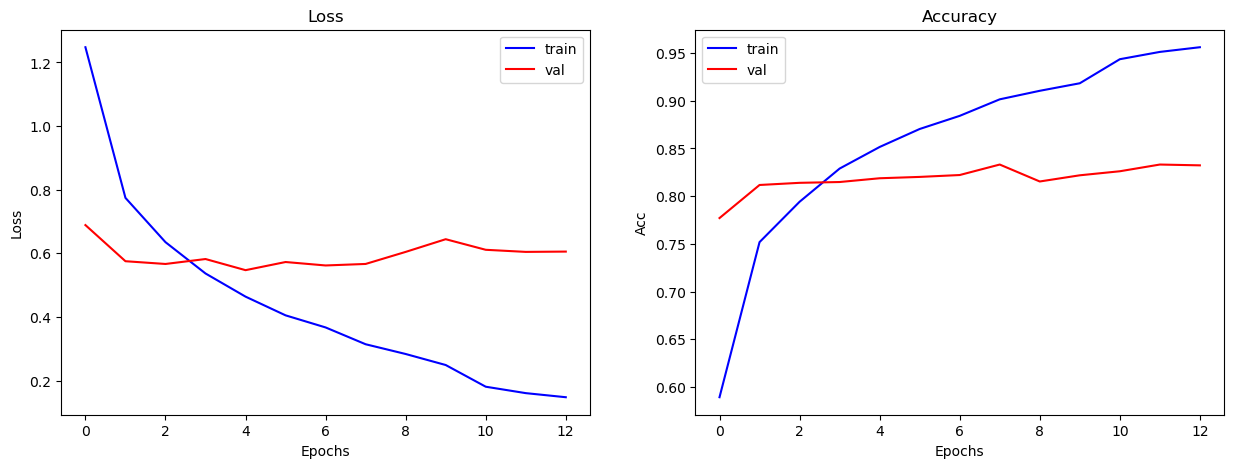

In [2]:
epochs = len(history_df['valid_acc'])
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_df['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_df['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_df['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_df['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()

plt.show()


# Evaluation

# Evaluation - Without Augmentation

# Swin Evaluation - Without Augmentation

In [12]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Swin Transformer
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("swin_transformer_galaxy10_decals.pth"))
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:57<00:00,  1.24it/s]


Test Loss: 0.7439, Test Acc: 0.8255


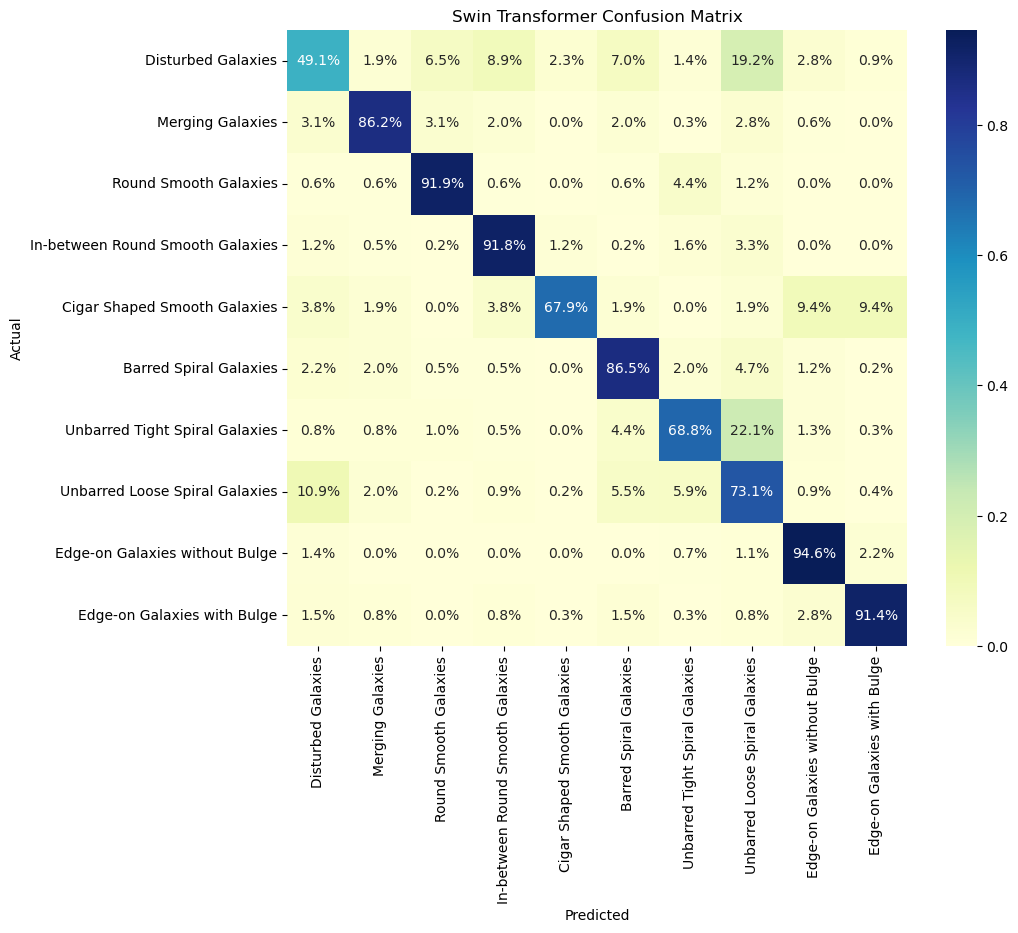

In [13]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, swin_all_labels, swin_all_preds = evaluate_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

conf_matrix = confusion_matrix(swin_all_labels, swin_all_preds)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Swin Transformer Confusion Matrix')
    plt.show()

class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)

In [5]:
print("Swin Transformer Classification Report:")
print(classification_report(swin_all_labels, swin_all_preds, target_names=class_names))

Swin Transformer Classification Report:
                                  precision    recall  f1-score   support

              Disturbed Galaxies       0.51      0.49      0.50       214
                Merging Galaxies       0.90      0.86      0.88       354
           Round Smooth Galaxies       0.93      0.92      0.93       496
In-between Round Smooth Galaxies       0.90      0.92      0.91       427
    Cigar Shaped Smooth Galaxies       0.75      0.68      0.71        53
          Barred Spiral Galaxies       0.81      0.87      0.84       401
  Unbarred Tight Spiral Galaxies       0.78      0.69      0.73       385
  Unbarred Loose Spiral Galaxies       0.69      0.73      0.71       543
  Edge-on Galaxies without Bulge       0.87      0.95      0.91       279
     Edge-on Galaxies with Bulge       0.96      0.91      0.93       396

                        accuracy                           0.83      3548
                       macro avg       0.81      0.80      0.80      3

## ViT Base Finetuned - Without Augmentation

In [6]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "ViT_without_augment"
criterion = torch.nn.CrossEntropyLoss()
# ViT
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(in_features=768, out_features=10, bias=True)
model.to(device)
model.load_state_dict(torch.load("ViT_without_augment.pth"))
model.eval()


C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:54<00:00,  1.25it/s]


Test Loss: 0.4602, Test Acc: 0.8616


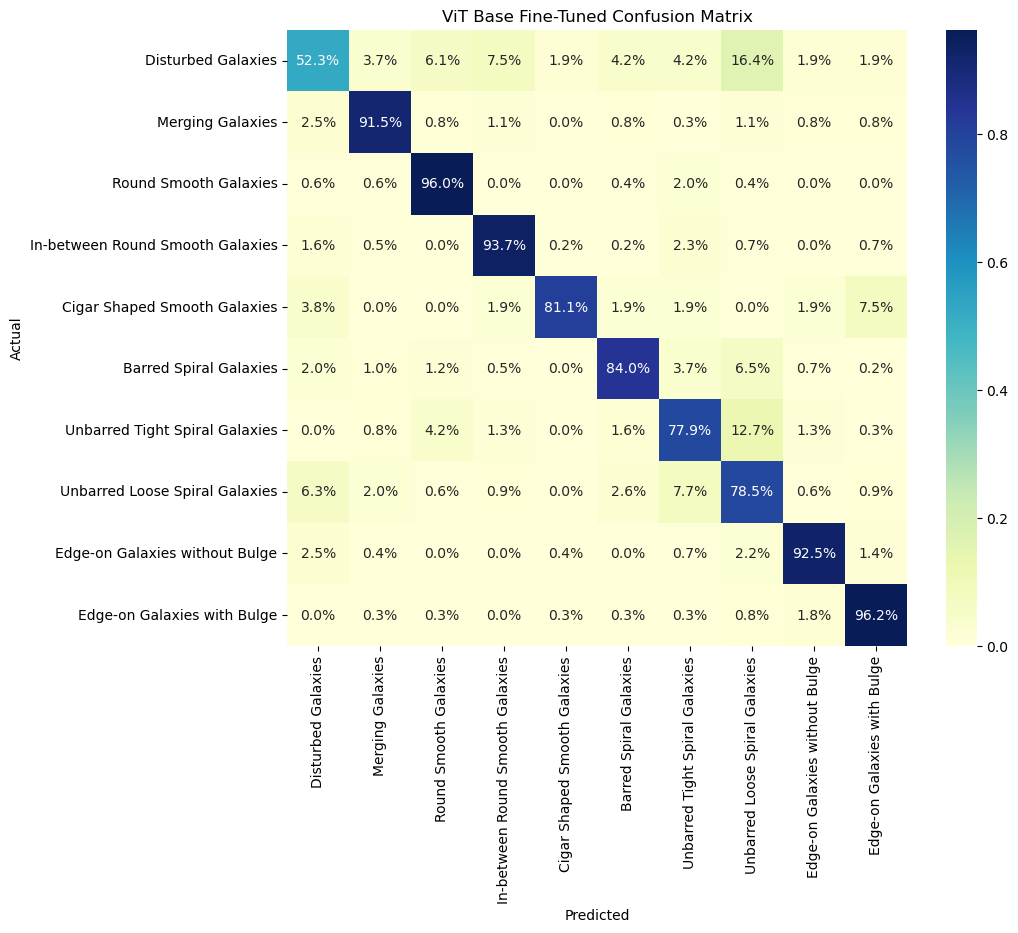

In [7]:
import torch
from torch.cuda.amp import autocast
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)  # Use outputs.logits for ViT
                
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.logits, 1)  # Use outputs.logits for ViT
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, vit_all_labels, vit_all_preds = evaluate_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

conf_matrix = confusion_matrix(vit_all_labels, vit_all_preds)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('ViT Base Fine-Tuned Confusion Matrix')
    plt.show()

# class names
class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)


In [8]:
print("ViT Base Fine-Tuned Classification Report:")
print(classification_report(vit_all_labels, vit_all_preds, target_names=class_names))


ViT Base Fine-Tuned Classification Report:
                                  precision    recall  f1-score   support

              Disturbed Galaxies       0.62      0.52      0.57       214
                Merging Galaxies       0.91      0.92      0.91       354
           Round Smooth Galaxies       0.92      0.96      0.94       496
In-between Round Smooth Galaxies       0.92      0.94      0.93       427
    Cigar Shaped Smooth Galaxies       0.86      0.81      0.83        53
          Barred Spiral Galaxies       0.90      0.84      0.87       401
  Unbarred Tight Spiral Galaxies       0.77      0.78      0.77       385
  Unbarred Loose Spiral Galaxies       0.77      0.78      0.78       543
  Edge-on Galaxies without Bulge       0.91      0.92      0.92       279
     Edge-on Galaxies with Bulge       0.94      0.96      0.95       396

                        accuracy                           0.86      3548
                       macro avg       0.85      0.84      0.85    

## DeiT - Without Augmentation

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Test Loss: 0.5658, Test Accuracy: 0.8179


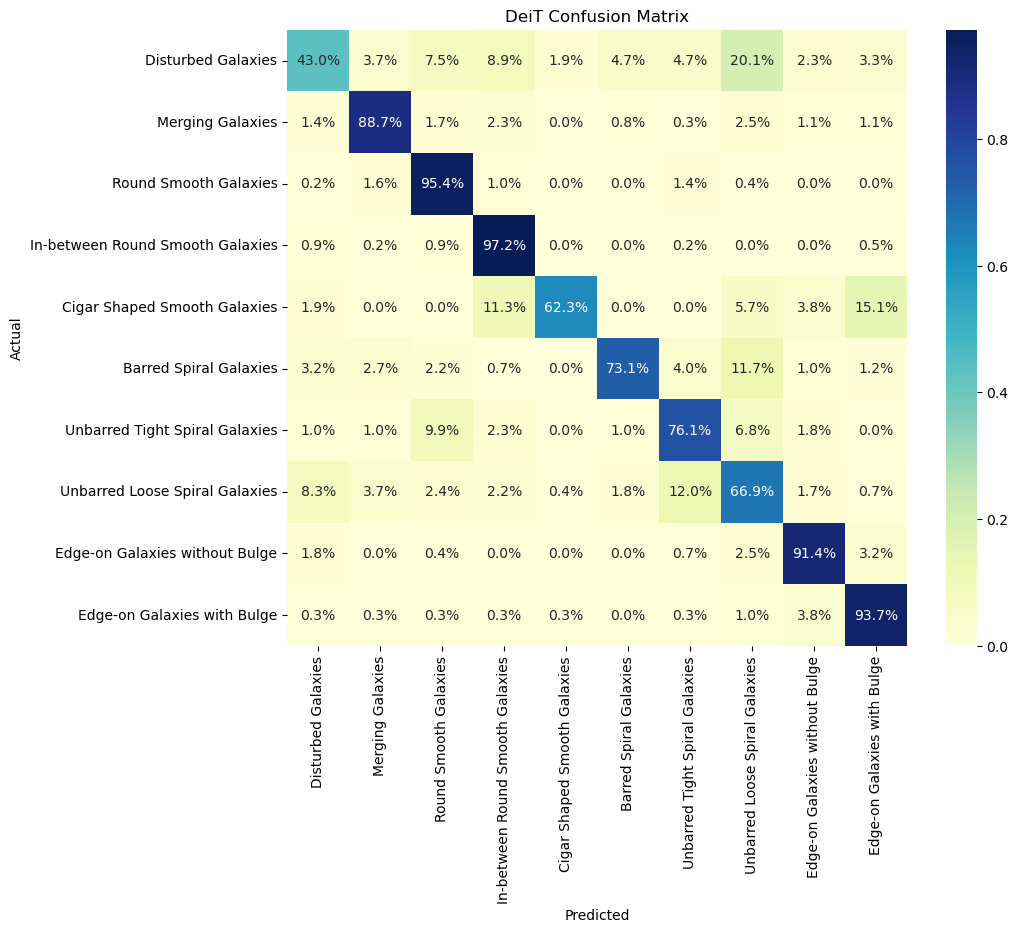

In [9]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# DeiT 
model = timm.create_model('deit_base_patch16_224', pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("deit_best_without_augment.pth"))
model.eval()

# loss function
criterion = torch.nn.CrossEntropyLoss()

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, deit_all_labels, deit_all_preds = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

conf_matrix = confusion_matrix(deit_all_labels, deit_all_preds)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('DeiT Confusion Matrix')
    plt.show()

# Galaxy10 
class_names = [
    "Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", 
    "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies", 
    "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", 
    "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", 
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)

In [10]:
print("DeiT Transformer Classification Report:")
print(classification_report(deit_all_labels, deit_all_preds, target_names=class_names))

DeiT Transformer Classification Report:
                                  precision    recall  f1-score   support

              Disturbed Galaxies       0.54      0.43      0.48       214
                Merging Galaxies       0.86      0.89      0.87       354
           Round Smooth Galaxies       0.84      0.95      0.89       496
In-between Round Smooth Galaxies       0.87      0.97      0.92       427
    Cigar Shaped Smooth Galaxies       0.82      0.62      0.71        53
          Barred Spiral Galaxies       0.92      0.73      0.81       401
  Unbarred Tight Spiral Galaxies       0.74      0.76      0.75       385
  Unbarred Loose Spiral Galaxies       0.72      0.67      0.69       543
  Edge-on Galaxies without Bulge       0.85      0.91      0.88       279
     Edge-on Galaxies with Bulge       0.90      0.94      0.92       396

                        accuracy                           0.82      3548
                       macro avg       0.81      0.79      0.79      3

# ResNet50 - Without Augmentation

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 0.5516, Test Accuracy: 0.8185


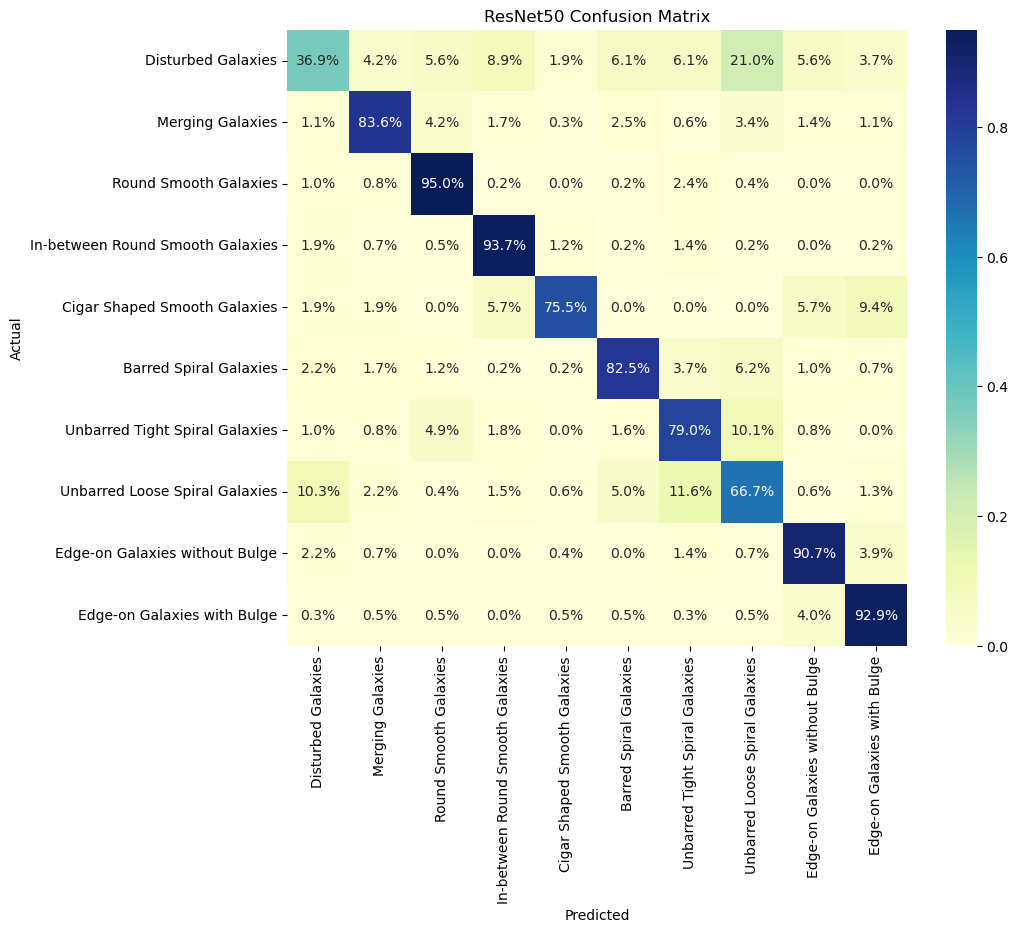

In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

criterion = torch.nn.CrossEntropyLoss()
# ResNet50 
model = models.resnet50(pretrained=False)  
model.fc = nn.Linear(model.fc.in_features, 10)
model_name = "resnet50_without_augment_new"

# GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load(os.path.join('./', model_name + "_cache.pth")))
model.eval()

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, resnet_all_labels, resnet_all_preds = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

conf_matrix = confusion_matrix(resnet_all_labels, resnet_all_preds)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('ResNet50 Confusion Matrix')
    plt.show()

# Class names - Galaxy10 dataset
class_names = [
    "Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", 
    "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies", 
    "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", 
    "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", 
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)


In [15]:
print("ResNet50 Transformer Classification Report:")
print(classification_report(resnet_all_labels, resnet_all_preds, target_names=class_names))

ResNet50 Transformer Classification Report:
                                  precision    recall  f1-score   support

              Disturbed Galaxies       0.46      0.37      0.41       214
                Merging Galaxies       0.87      0.84      0.85       354
           Round Smooth Galaxies       0.89      0.95      0.92       496
In-between Round Smooth Galaxies       0.90      0.94      0.92       427
    Cigar Shaped Smooth Galaxies       0.70      0.75      0.73        53
          Barred Spiral Galaxies       0.85      0.83      0.84       401
  Unbarred Tight Spiral Galaxies       0.72      0.79      0.76       385
  Unbarred Loose Spiral Galaxies       0.74      0.67      0.70       543
  Edge-on Galaxies without Bulge       0.85      0.91      0.88       279
     Edge-on Galaxies with Bulge       0.90      0.93      0.92       396

                        accuracy                           0.82      3548
                       macro avg       0.79      0.80      0.79   

# With Augmentation

# Swin Transformer

In [25]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Swin Transformer 
criterion = torch.nn.CrossEntropyLoss()
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("swin_model_epoch_10.pth"))
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:54<00:00,  1.25it/s]


Test Loss: 0.4495, Test Acc: 0.8557


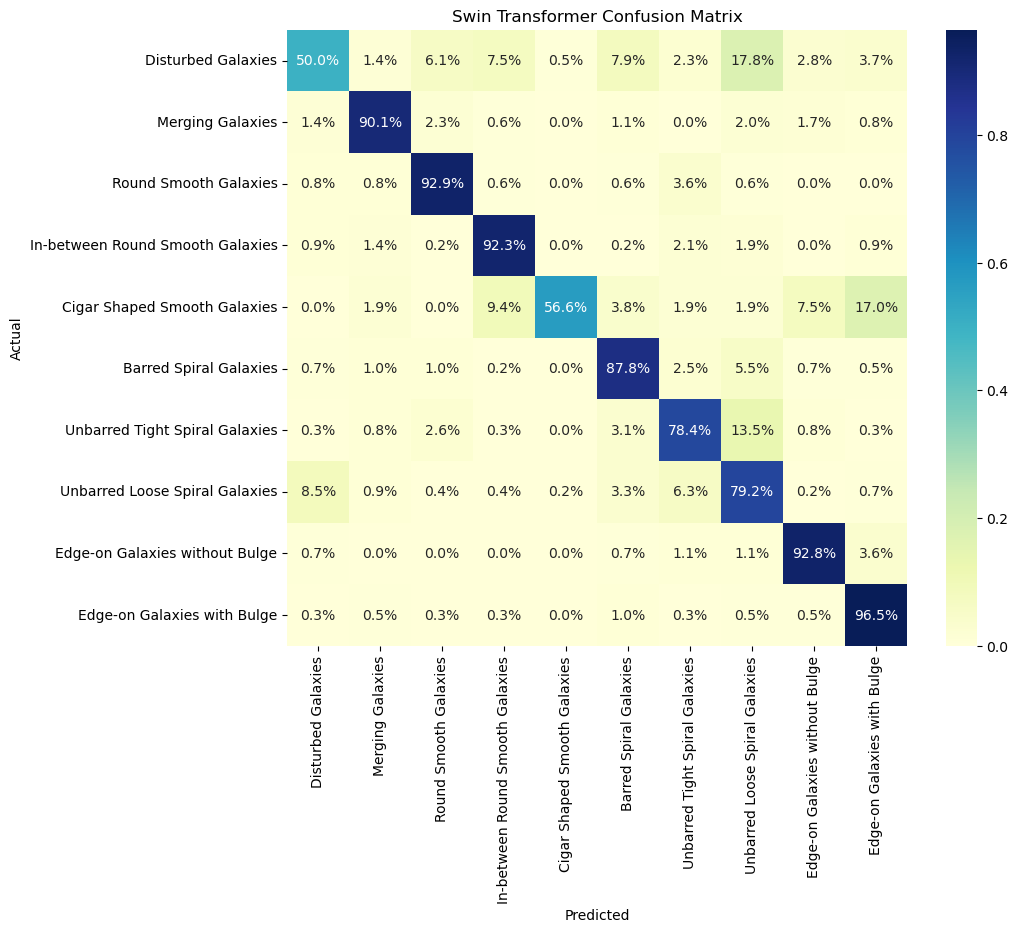

In [26]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, swin_all_labels, swin_all_preds = evaluate_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

conf_matrix = confusion_matrix(swin_all_labels, swin_all_preds)

# confusion matrix plot
def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Swin Transformer Confusion Matrix')
    plt.show()

# class names
class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)

In [27]:
print("Swin Transformer Classification Report:",classification_report(swin_all_labels, swin_all_preds, target_names=class_names))

Swin Transformer Classification Report:                                   precision    recall  f1-score   support

              Disturbed Galaxies       0.62      0.50      0.55       214
                Merging Galaxies       0.92      0.90      0.91       354
           Round Smooth Galaxies       0.92      0.93      0.93       496
In-between Round Smooth Galaxies       0.93      0.92      0.92       427
    Cigar Shaped Smooth Galaxies       0.94      0.57      0.71        53
          Barred Spiral Galaxies       0.85      0.88      0.86       401
  Unbarred Tight Spiral Galaxies       0.79      0.78      0.79       385
  Unbarred Loose Spiral Galaxies       0.76      0.79      0.78       543
  Edge-on Galaxies without Bulge       0.91      0.93      0.92       279
     Edge-on Galaxies with Bulge       0.90      0.96      0.93       396

                        accuracy                           0.86      3548
                       macro avg       0.85      0.82      0.83      3

# ViT Base Finetuned

In [28]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "gz2_hug_vit_010822B"
criterion = torch.nn.CrossEntropyLoss()
# ViT
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(in_features=768, out_features=10, bias=True)
model.to(device)
model.load_state_dict(torch.load("gz2_hug_vit_010822B.pth"))
model.eval()


C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:53<00:00,  1.25it/s]


Test Loss: 0.4083, Test Acc: 0.8670


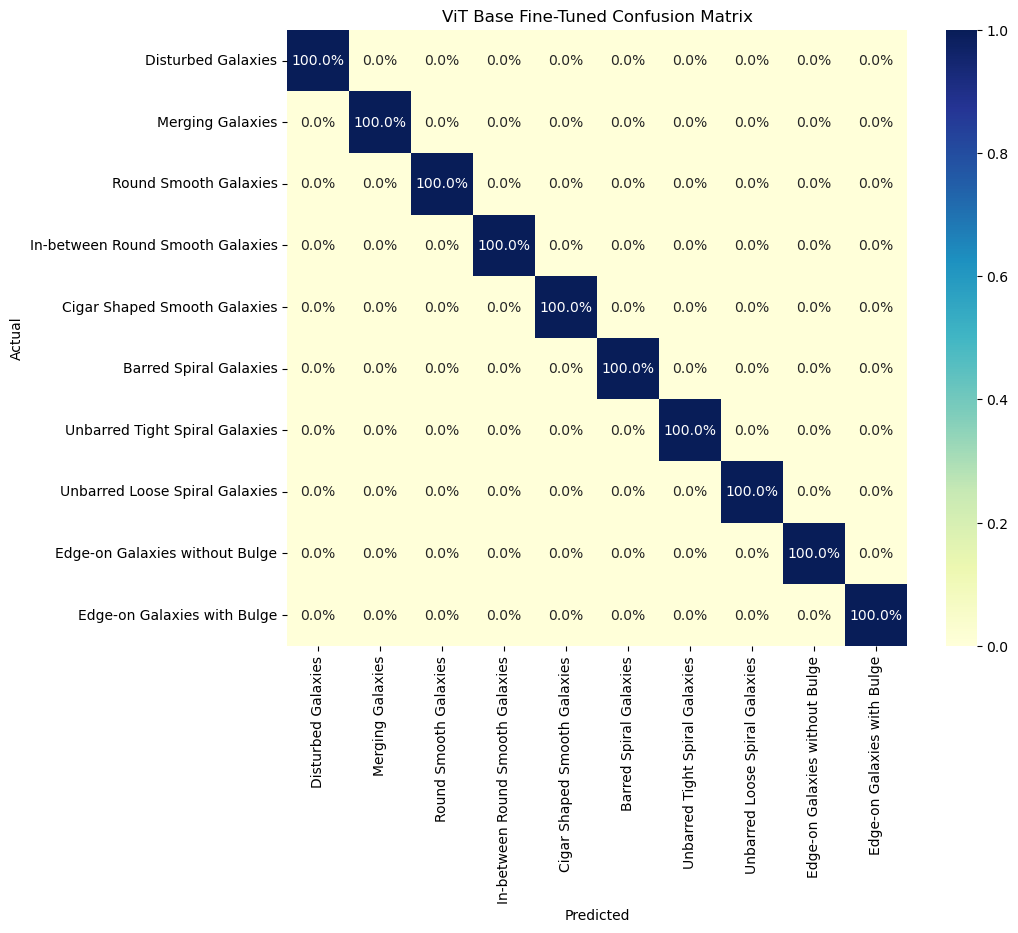

In [29]:
import torch
from torch.cuda.amp import autocast
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)  
                
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.logits, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, vit_all_labels, vit_all_preds = evaluate_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

conf_matrix = confusion_matrix(vit_all_labels, vit_all_labels)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('ViT Base Fine-Tuned Confusion Matrix')
    plt.show()

class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)


In [30]:
print("ViT Base Fine-Tuned Classification Report:",classification_report(vit_all_labels, vit_all_preds, target_names=class_names))


ViT Base Fine-Tuned Classification Report:                                   precision    recall  f1-score   support

              Disturbed Galaxies       0.65      0.49      0.56       214
                Merging Galaxies       0.90      0.90      0.90       354
           Round Smooth Galaxies       0.90      0.96      0.93       496
In-between Round Smooth Galaxies       0.91      0.96      0.93       427
    Cigar Shaped Smooth Galaxies       0.88      0.87      0.88        53
          Barred Spiral Galaxies       0.89      0.85      0.87       401
  Unbarred Tight Spiral Galaxies       0.79      0.84      0.81       385
  Unbarred Loose Spiral Galaxies       0.78      0.77      0.78       543
  Edge-on Galaxies without Bulge       0.94      0.94      0.94       279
     Edge-on Galaxies with Bulge       0.94      0.96      0.95       396

                        accuracy                           0.87      3548
                       macro avg       0.86      0.85      0.85    

# DeiT Evaluation

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Test Loss: 0.4975, Test Accuracy: 0.8368


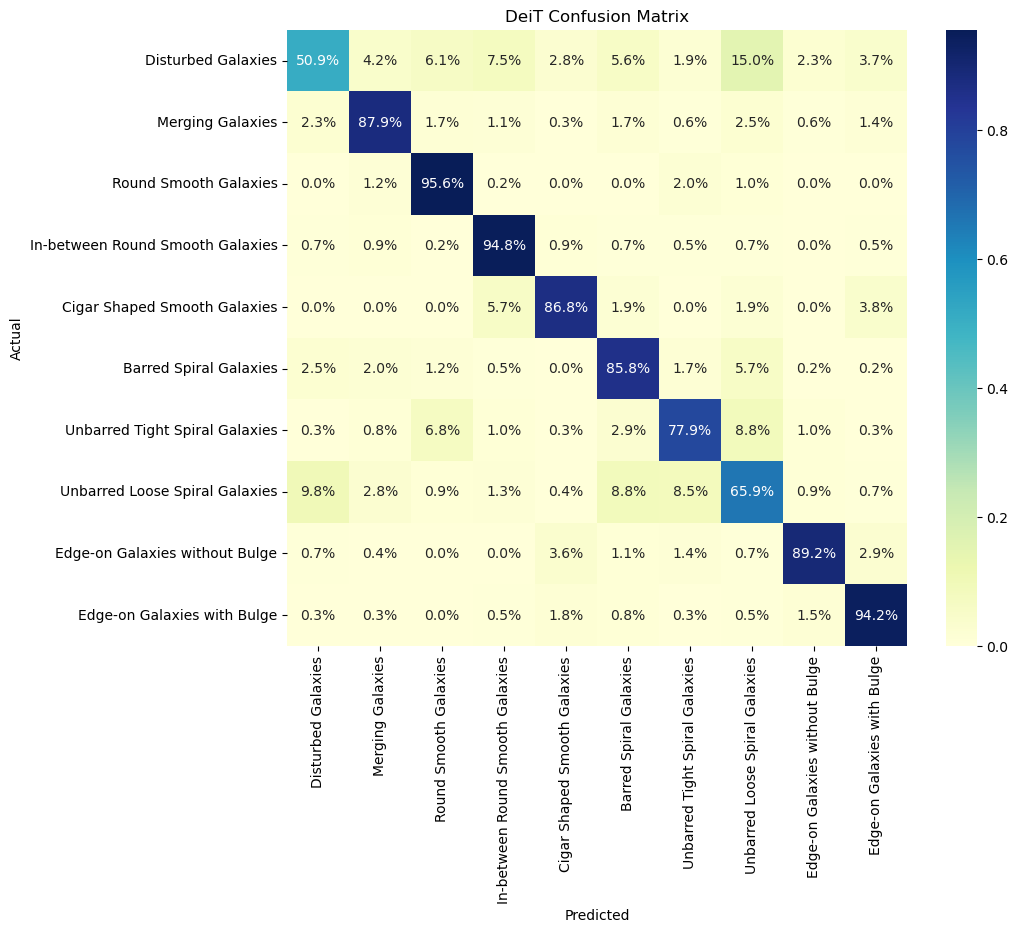

In [31]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Loading DeiT model
model = timm.create_model('deit_base_patch16_224', pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("deit_galaxy10.pth"))
model.eval()

criterion = torch.nn.CrossEntropyLoss()

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, deit_all_labels, deit_all_preds = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

conf_matrix = confusion_matrix(deit_all_labels, deit_all_preds)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('DeiT Confusion Matrix')
    plt.show()

# Galaxy10 dataset
class_names = [
    "Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", 
    "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies", 
    "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", 
    "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", 
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)

In [33]:
print("DeiT Classification Report:",classification_report(deit_all_labels, deit_all_preds, target_names=class_names))


DeiT Classification Report:                                   precision    recall  f1-score   support

              Disturbed Galaxies       0.58      0.51      0.54       214
                Merging Galaxies       0.87      0.88      0.87       354
           Round Smooth Galaxies       0.89      0.96      0.92       496
In-between Round Smooth Galaxies       0.91      0.95      0.93       427
    Cigar Shaped Smooth Galaxies       0.60      0.87      0.71        53
          Barred Spiral Galaxies       0.80      0.86      0.83       401
  Unbarred Tight Spiral Galaxies       0.80      0.78      0.79       385
  Unbarred Loose Spiral Galaxies       0.76      0.66      0.71       543
  Edge-on Galaxies without Bulge       0.92      0.89      0.90       279
     Edge-on Galaxies with Bulge       0.92      0.94      0.93       396

                        accuracy                           0.84      3548
                       macro avg       0.81      0.83      0.81      3548
        

# ResNet50

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 0.5304, Test Accuracy: 0.8315


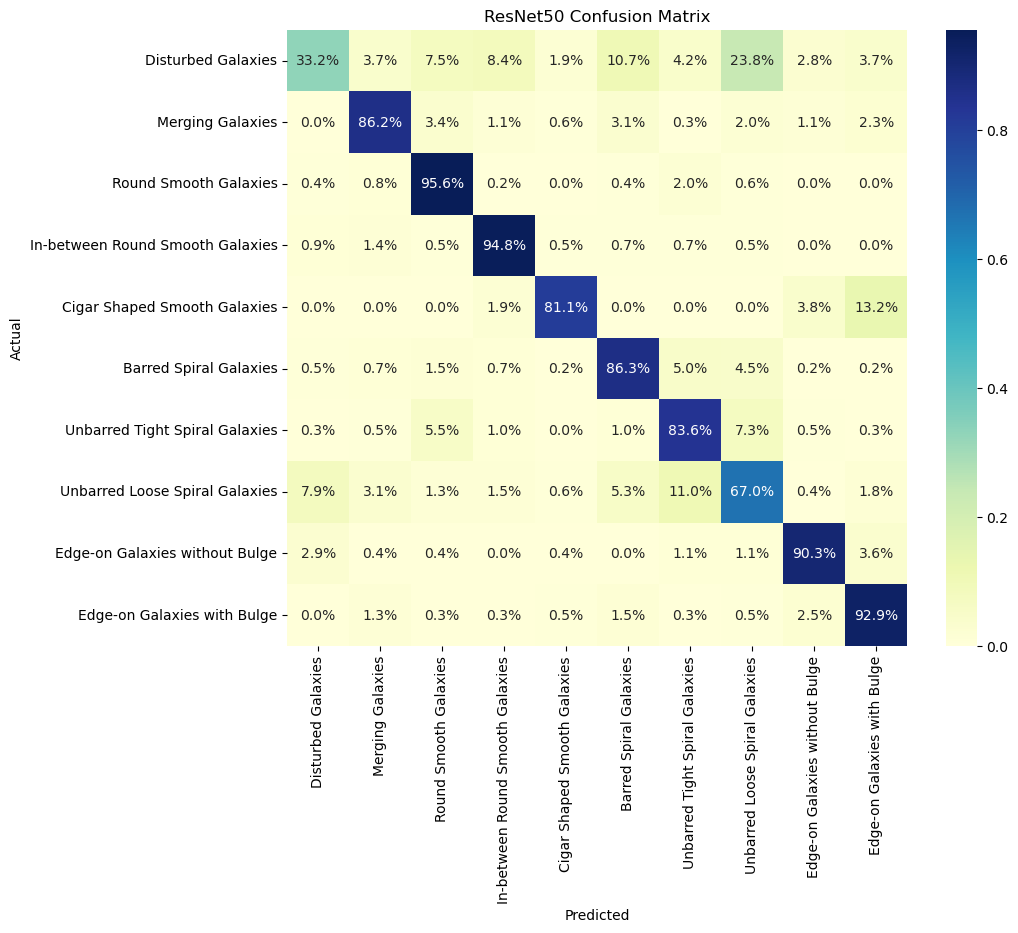

In [34]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

criterion = torch.nn.CrossEntropyLoss()

model = models.resnet50(pretrained=False)  
model.fc = nn.Linear(model.fc.in_features, 10)
model_name = "gz2_resnet50_A"

# GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load(os.path.join('./', model_name + "_cache.pth")))
model.eval()

# evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds

test_loss, test_acc, resnet_all_labels, resnet_all_preds = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

conf_matrix = confusion_matrix(resnet_all_labels, resnet_all_preds)

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('ResNet50 Confusion Matrix')
    plt.show()

# Class names for Galaxy10 dataset
class_names = [
    "Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", 
    "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies", 
    "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", 
    "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", 
    "Edge-on Galaxies with Bulge"
]

plot_confusion_matrix(conf_matrix, class_names)


In [35]:
print("ResNet50 Classification Report:",classification_report(all_labels, all_preds, target_names=class_names))


NameError: name 'all_labels' is not defined

In [13]:
models = {
    "Swin Transformer": (swin_all_labels, swin_all_preds),
    "ViT Base Fine-Tuned": (vit_all_labels, vit_all_preds),
    "DeiT": (deit_all_labels, deit_all_preds),
    "ResNet50": (resnet_all_labels, resnet_all_preds)
}

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

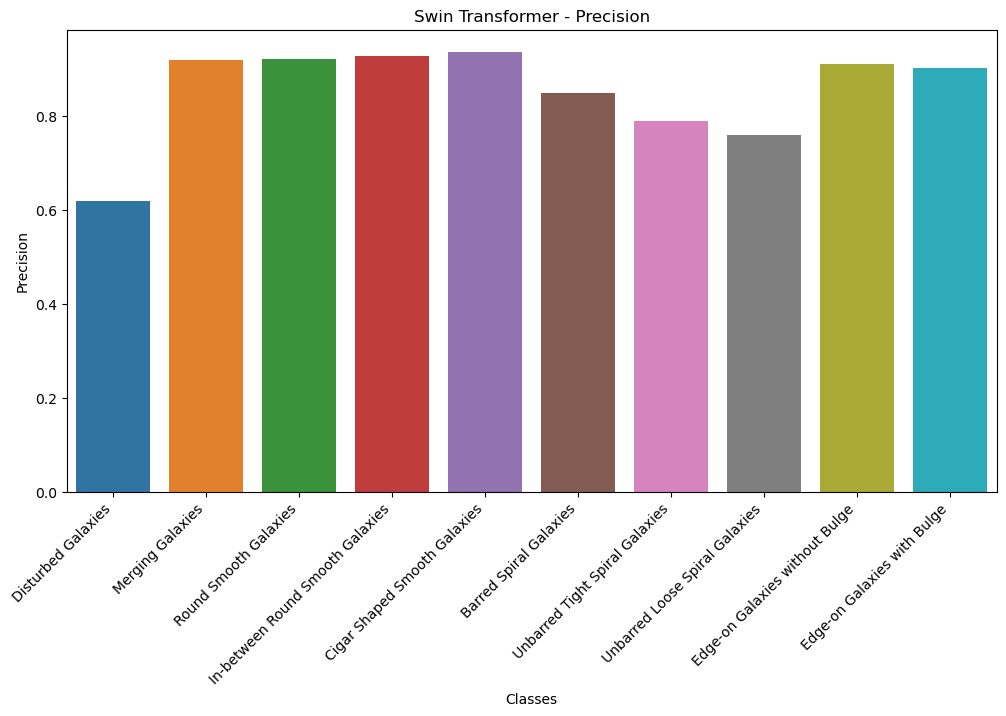

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

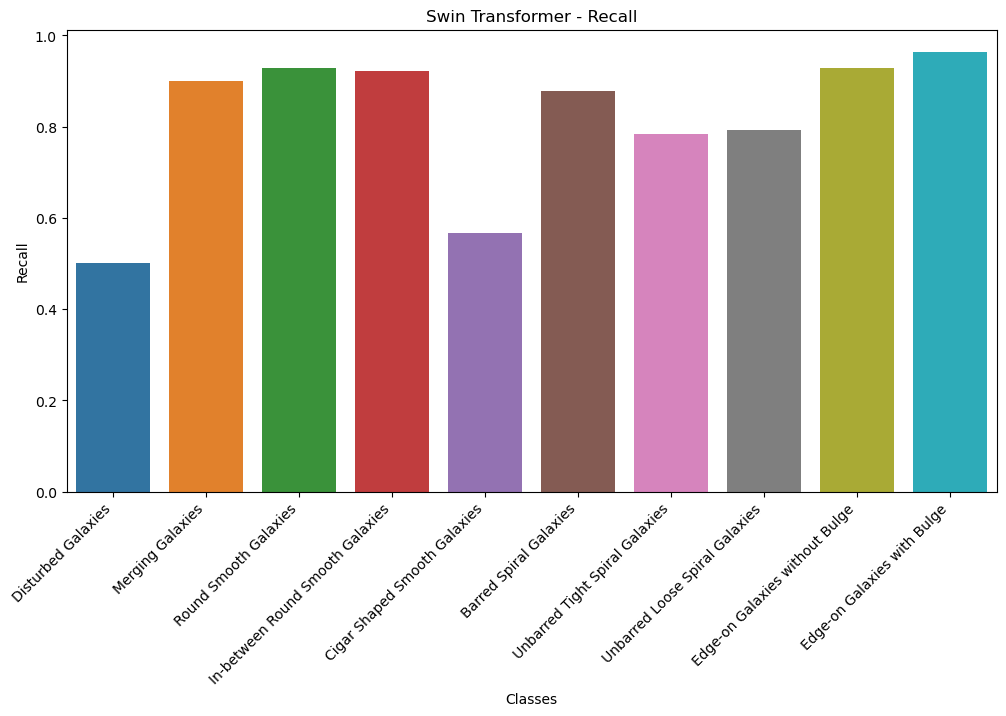

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

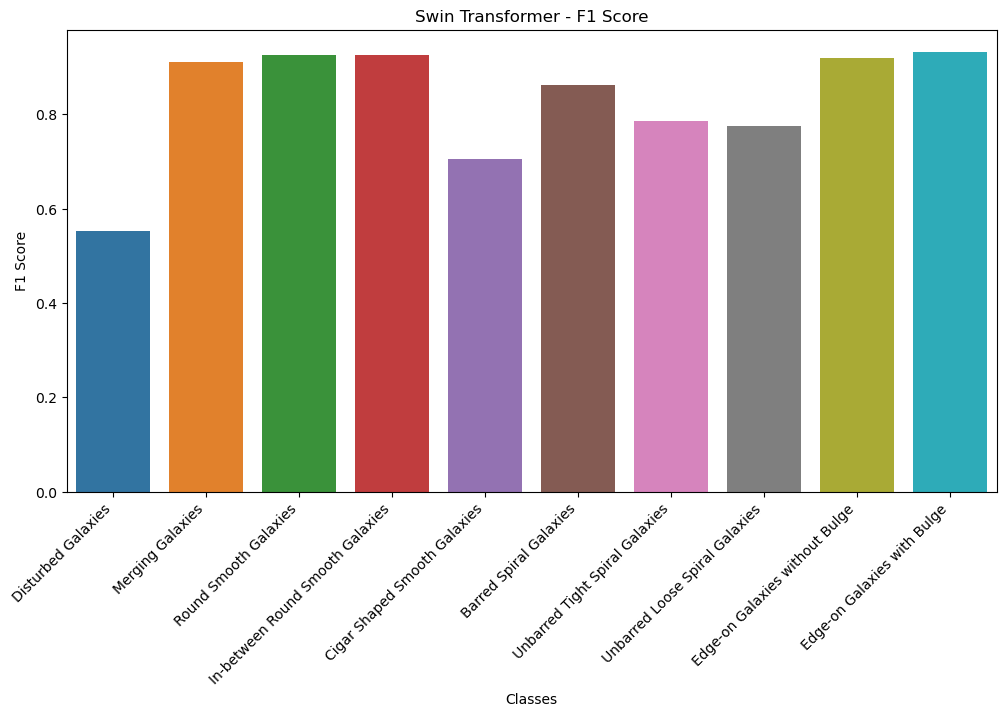

Swin Transformer - Accuracy: 0.8557


C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

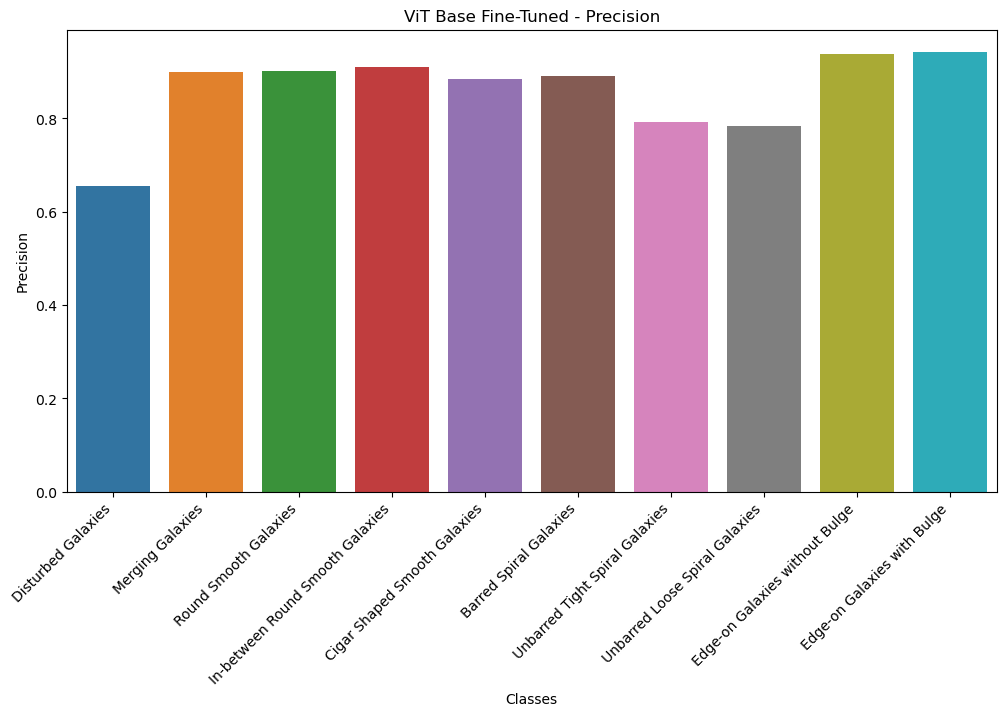

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

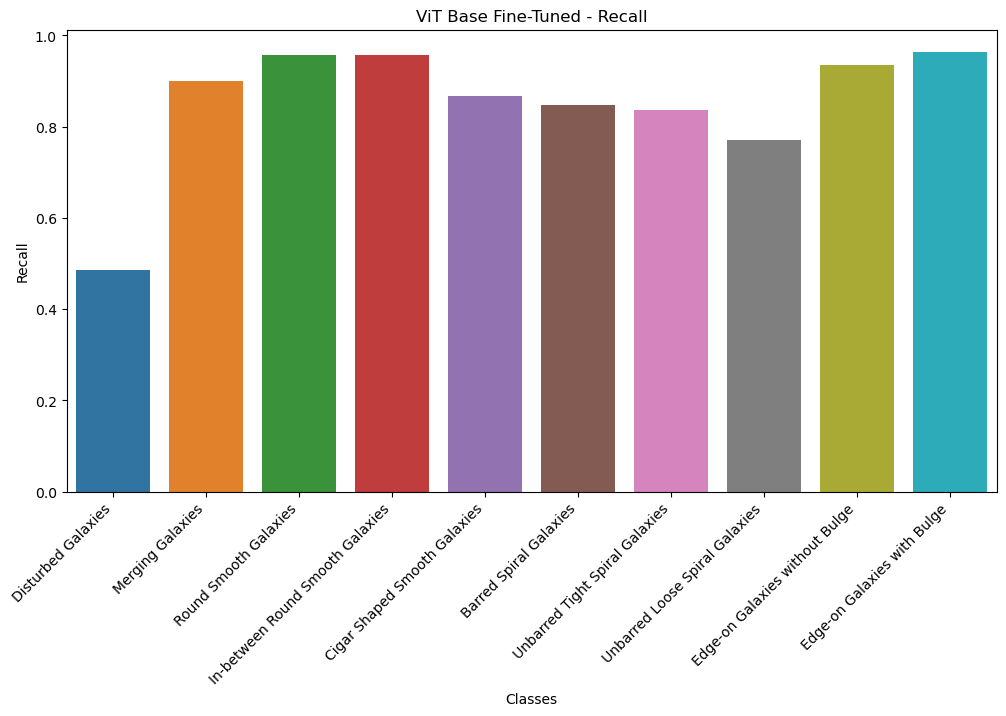

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

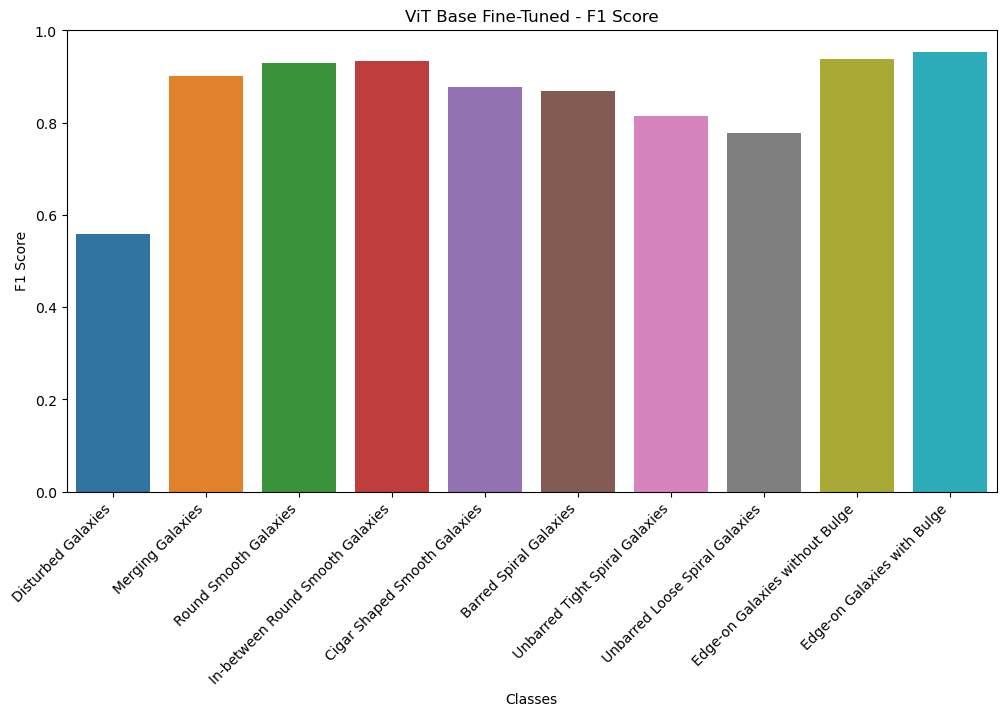

ViT Base Fine-Tuned - Accuracy: 0.8670


C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

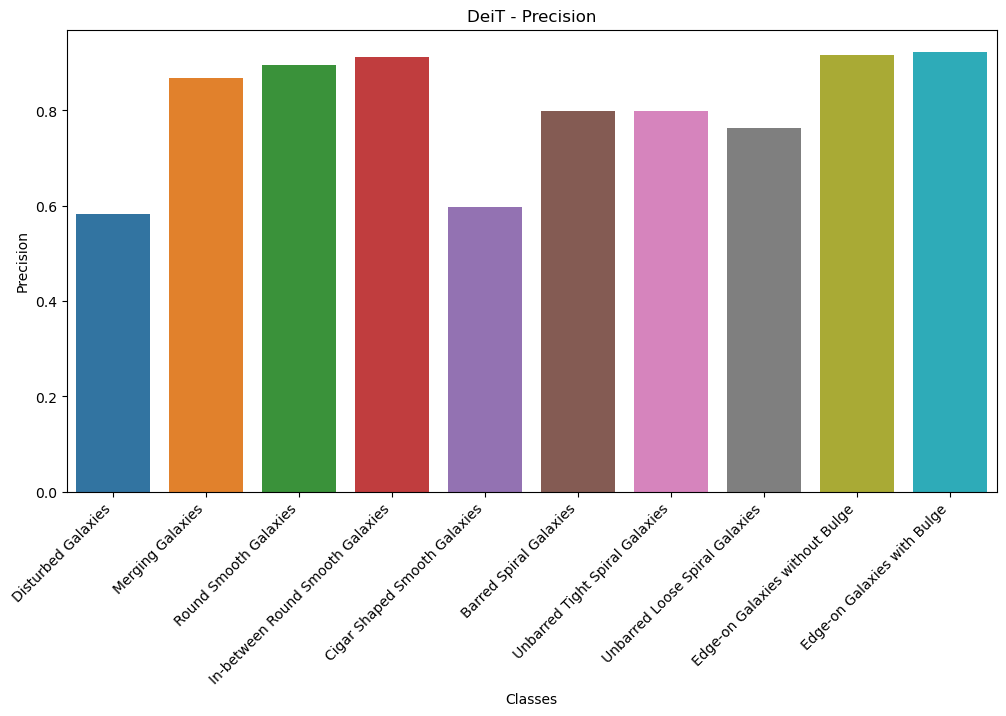

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

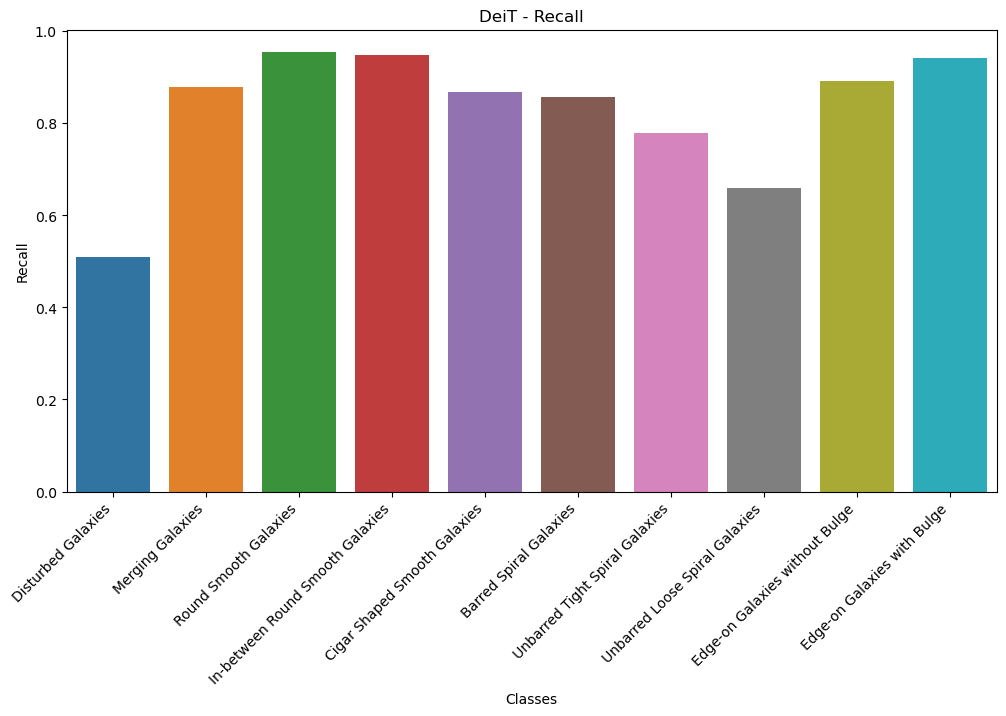

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

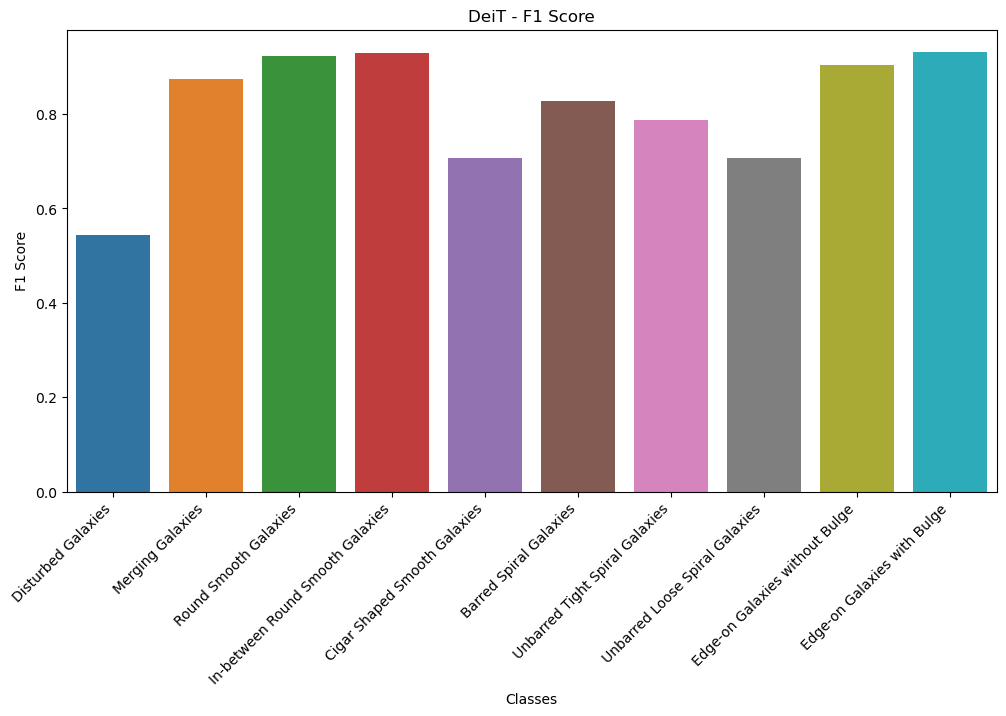

DeiT - Accuracy: 0.8368


C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

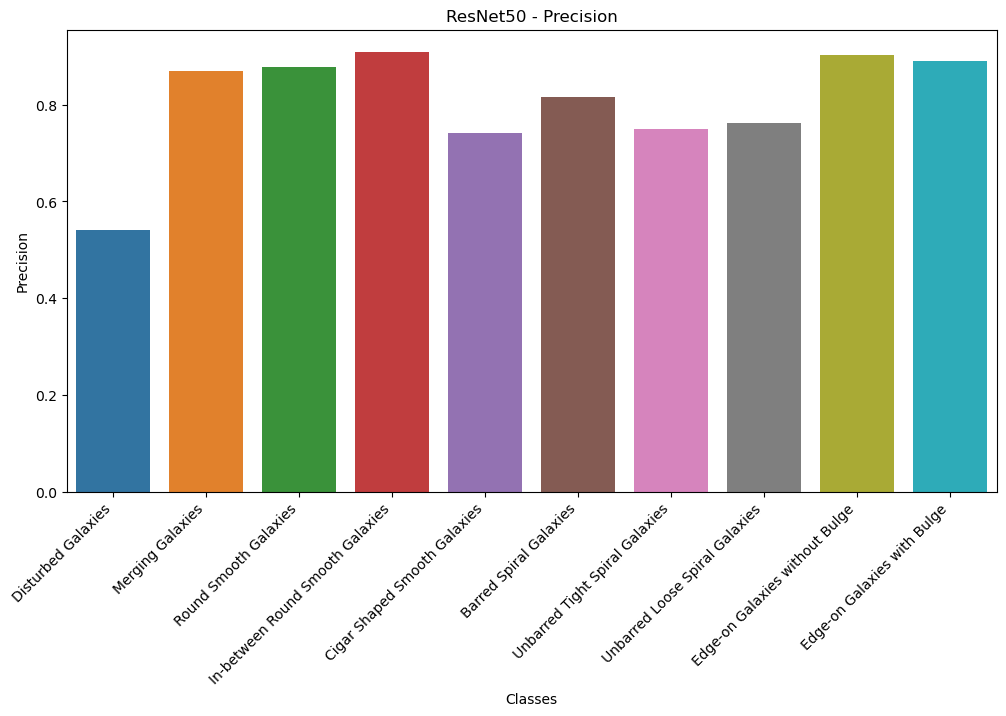

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

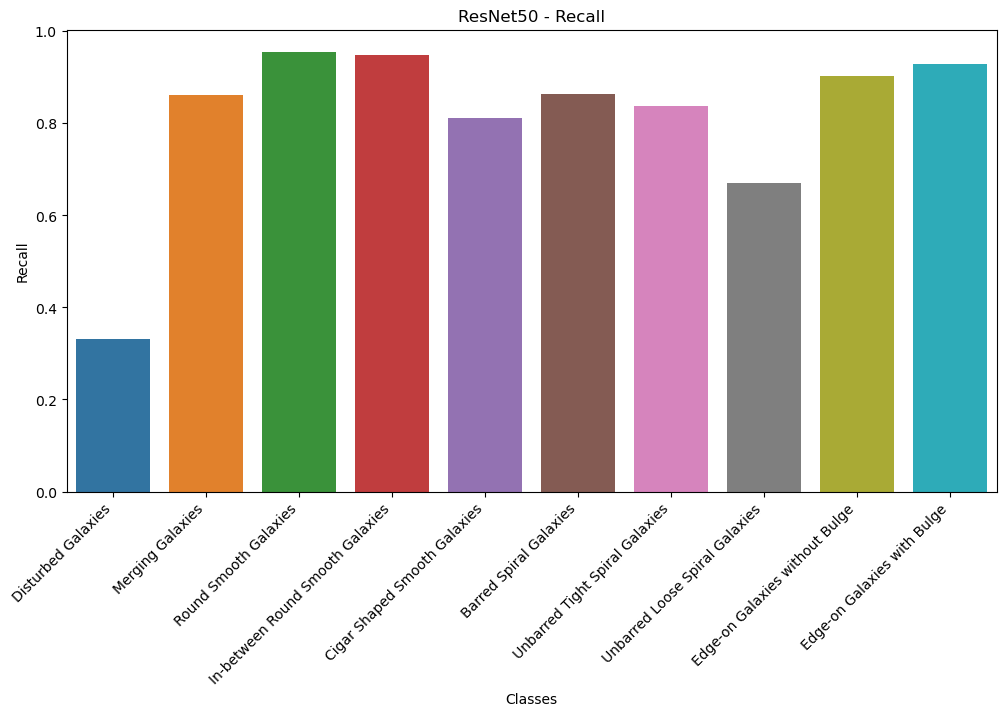

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  

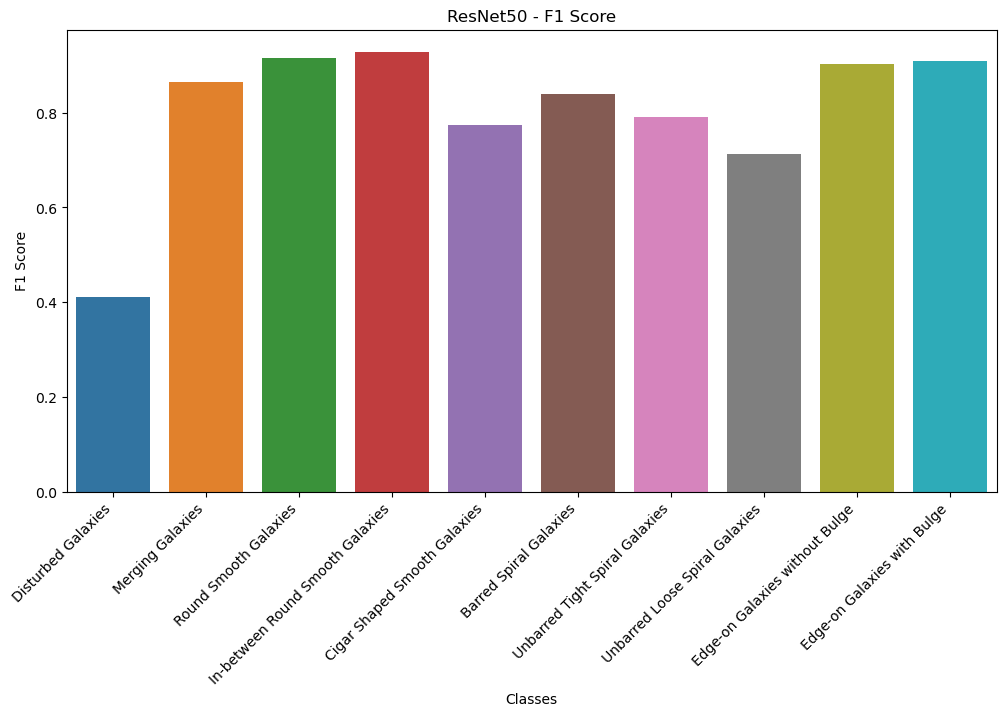

ResNet50 - Accuracy: 0.8315


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_class_metrics(all_labels, all_preds, class_names):
    precision = precision_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    recall = recall_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    f1 = f1_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    accuracy = accuracy_score(all_labels, all_preds)
    
    return precision, recall, f1, accuracy

def plot_metrics(metric_values, metric_name, class_names, model_name):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names, y=metric_values)
    plt.title(f'{model_name} - {metric_name}')
    plt.xlabel('Classes')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha="right")
    plt.show()


class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

for model_name, (all_labels, all_preds) in models.items():
    precision, recall, f1, accuracy = compute_class_metrics(all_labels, all_preds, class_names)
    
    plot_metrics(precision, "Precision", class_names, model_name)
    
    plot_metrics(recall, "Recall", class_names, model_name)
    
    plot_metrics(f1, "F1 Score", class_names, model_name)
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}")


# Model Comparisons - Precision - Recall - F1 Score - Accuracy 
## With Data Augmentation

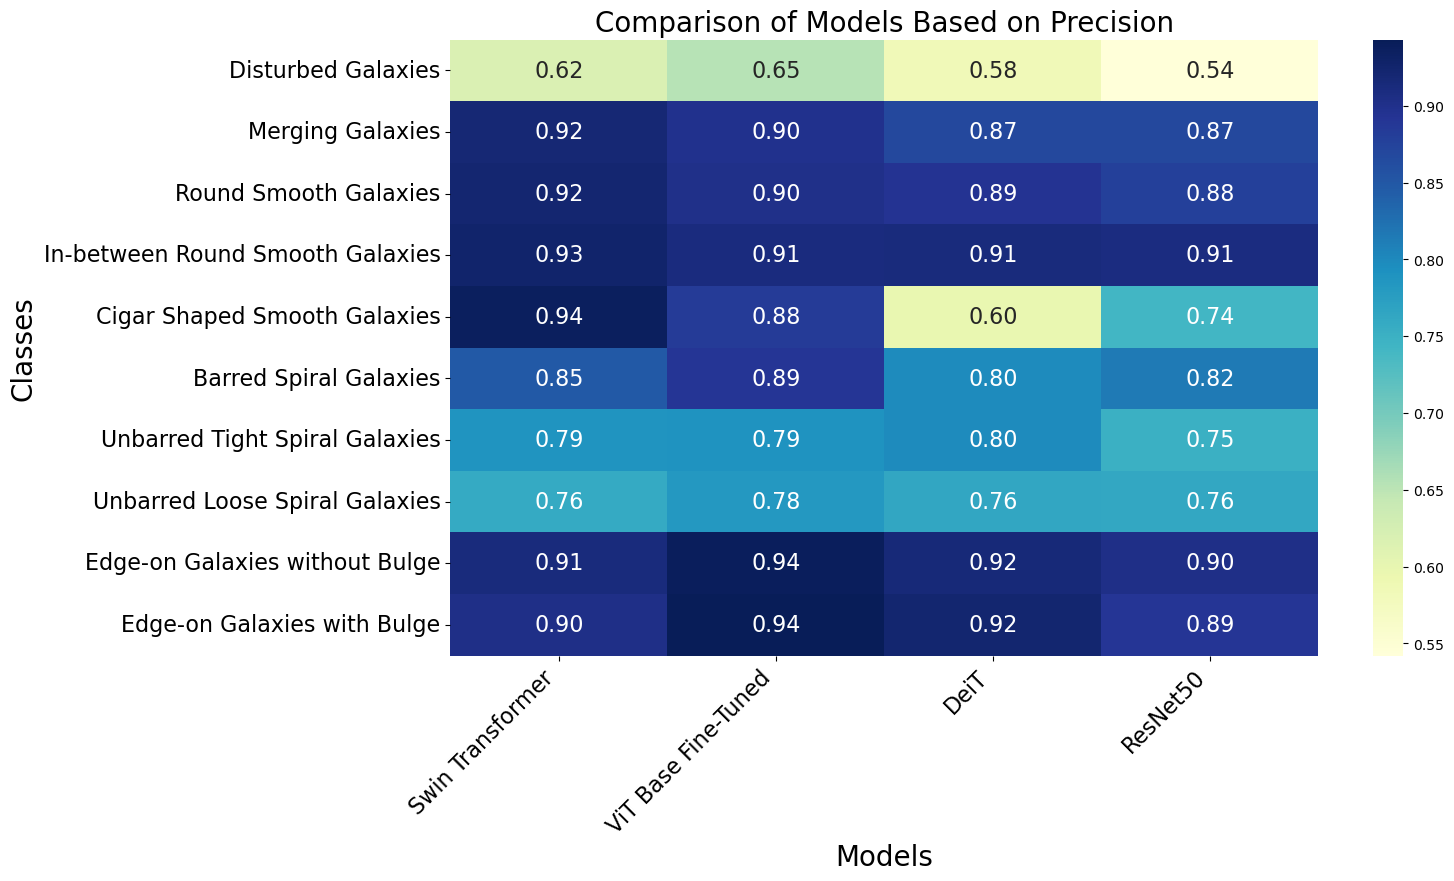

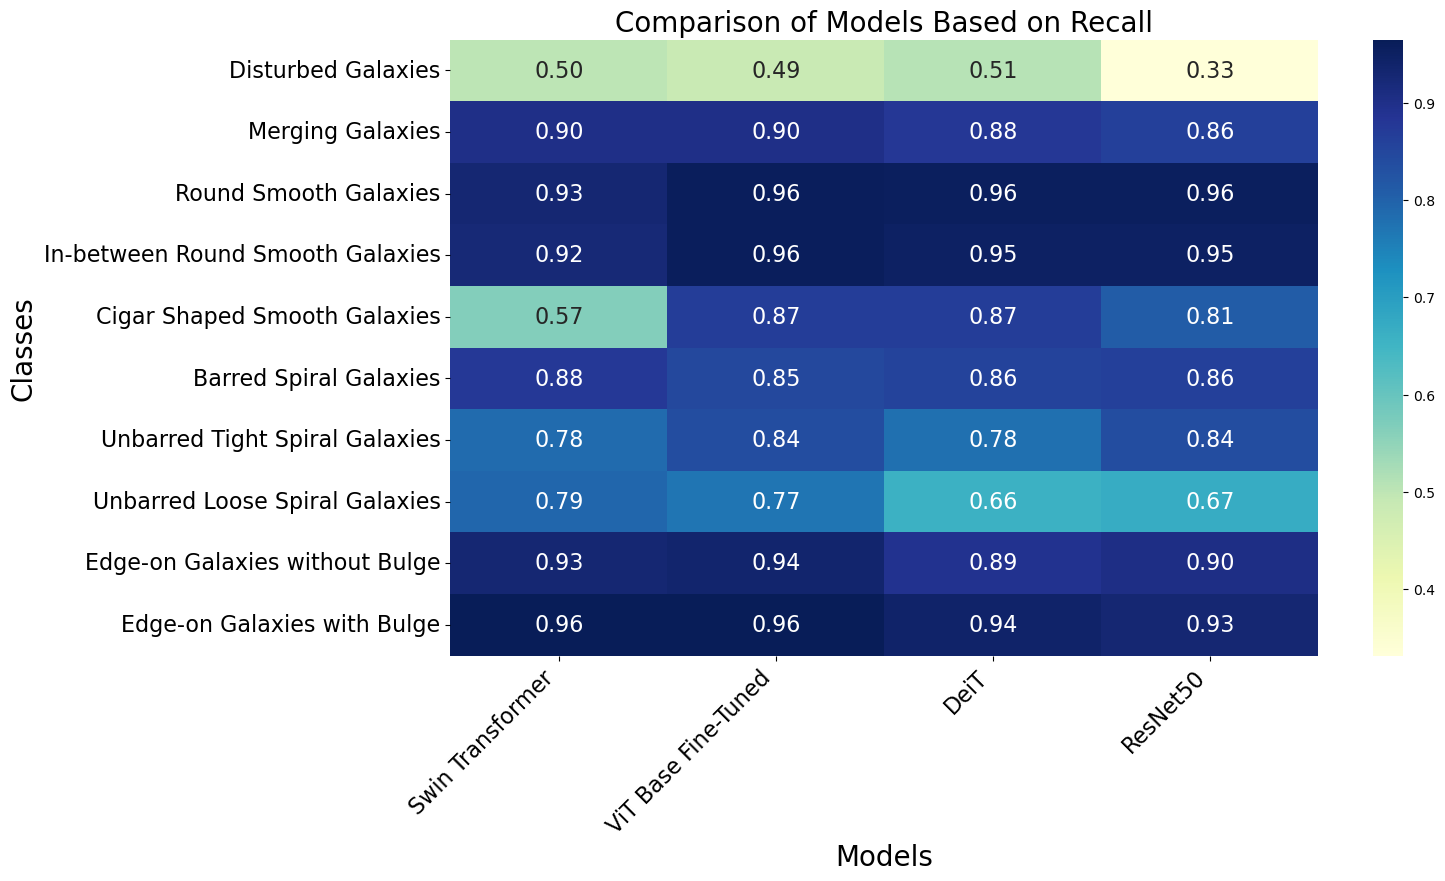

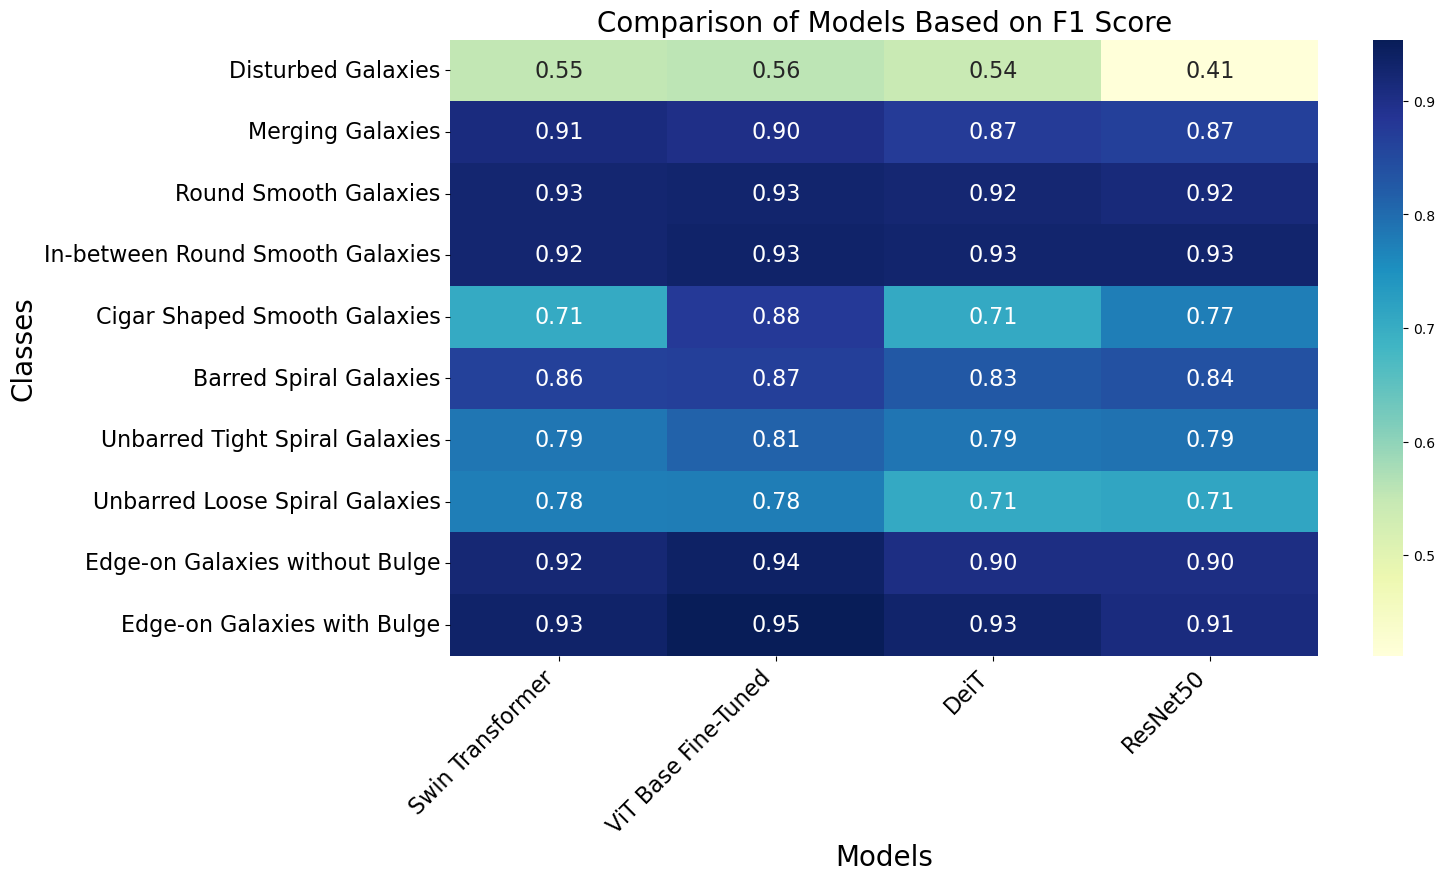

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


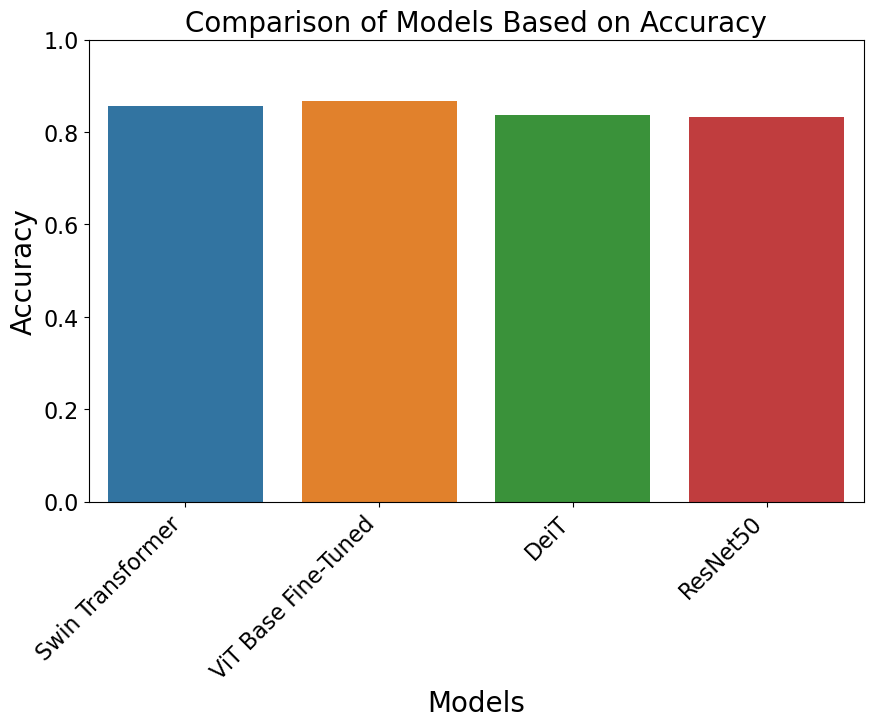

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def compute_class_metrics(all_labels, all_preds, class_names):
    precision = precision_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    recall = recall_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    f1 = f1_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    accuracy = accuracy_score(all_labels, all_preds)
    
    return precision, recall, f1, accuracy


def plot_metrics(models, metric_name, metric_index, class_names):
    metric_data = {model_name: compute_class_metrics(labels, preds, class_names)[metric_index] 
                   for model_name, (labels, preds) in models.items()}

    metrics_df = pd.DataFrame(metric_data, index=class_names)

    plt.figure(figsize=(14, 8))
    sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.2f', annot_kws={"size": 16})
    plt.title(f'Comparison of Models Based on {metric_name}', fontsize=20)
    plt.ylabel('Classes', fontsize=20)
    plt.xlabel('Models', fontsize=20)
    plt.xticks(rotation=45, ha="right", fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

models = {
    "Swin Transformer": (swin_all_labels, swin_all_preds),
    "ViT Base Fine-Tuned": (vit_all_labels, vit_all_preds),
    "DeiT": (deit_all_labels, deit_all_preds),
    "ResNet50": (resnet_all_labels, resnet_all_preds)
}

class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

import pandas as pd

plot_metrics(models, "Precision", 0, class_names)

plot_metrics(models, "Recall", 1, class_names)

plot_metrics(models, "F1 Score", 2, class_names)

# Accuracy for each model
accuracies = {model_name: compute_class_metrics(labels, preds, class_names)[3] for model_name, (labels, preds) in models.items()}
accuracy_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])

# Accuracy PLot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Comparison of Models Based on Accuracy', fontsize=20)
plt.xlabel('Models', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 1)
plt.show()


# Model Comparisons - Precision - Recall - F1 Score - Accuracy

## Without Augmentation

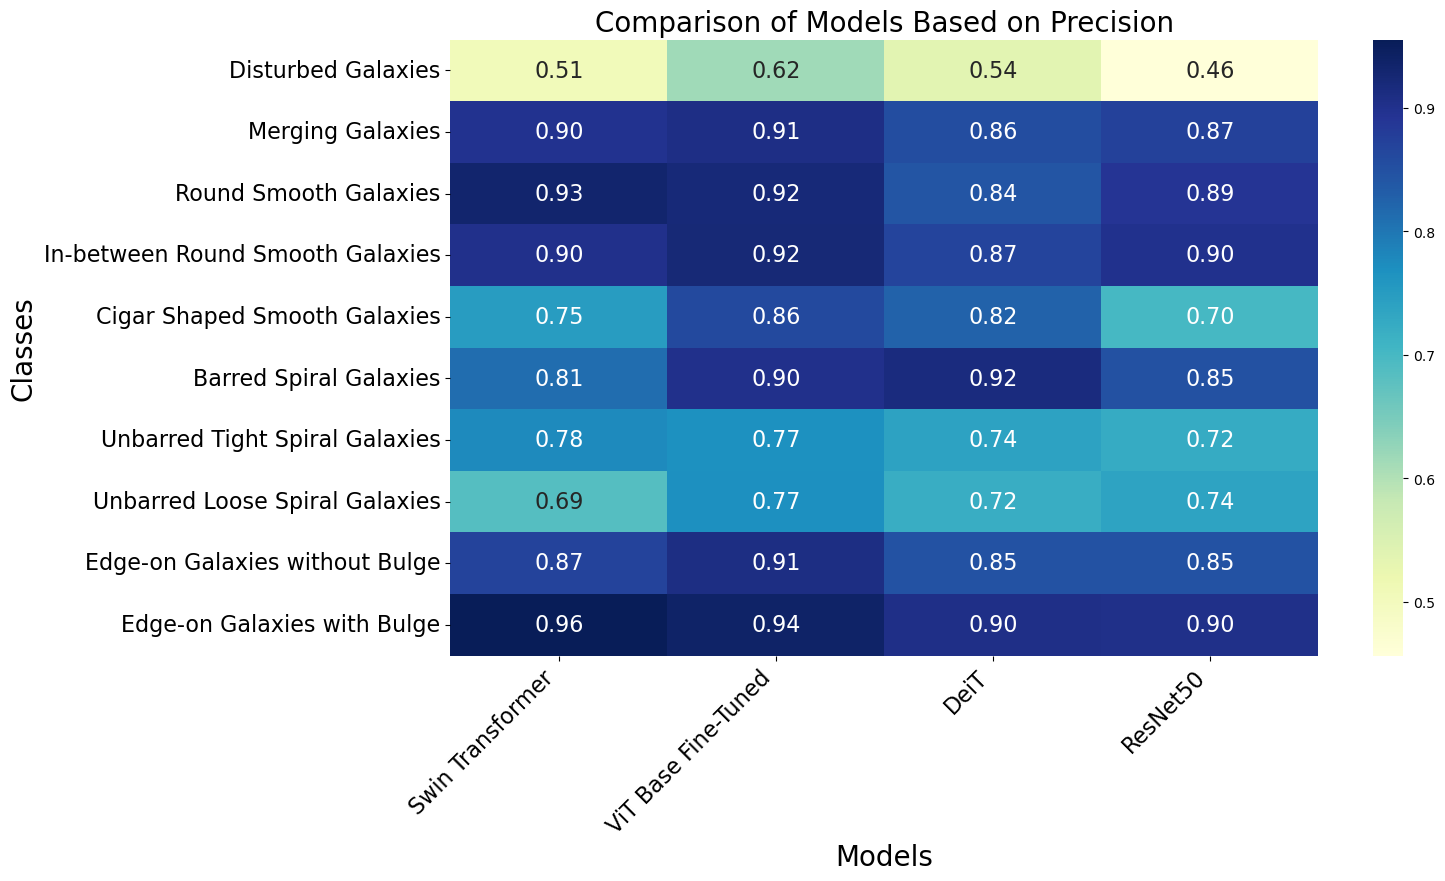

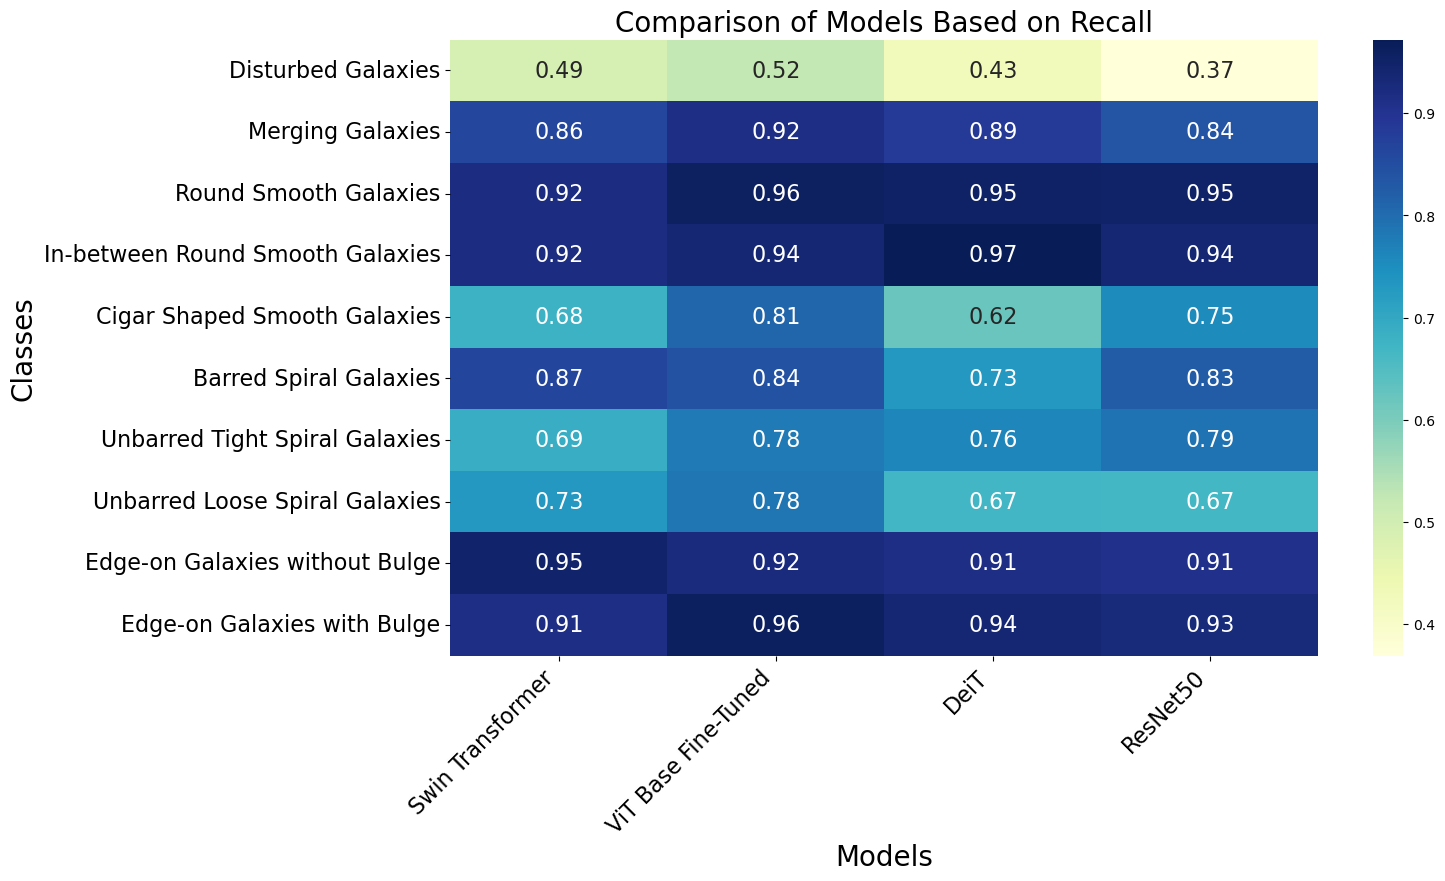

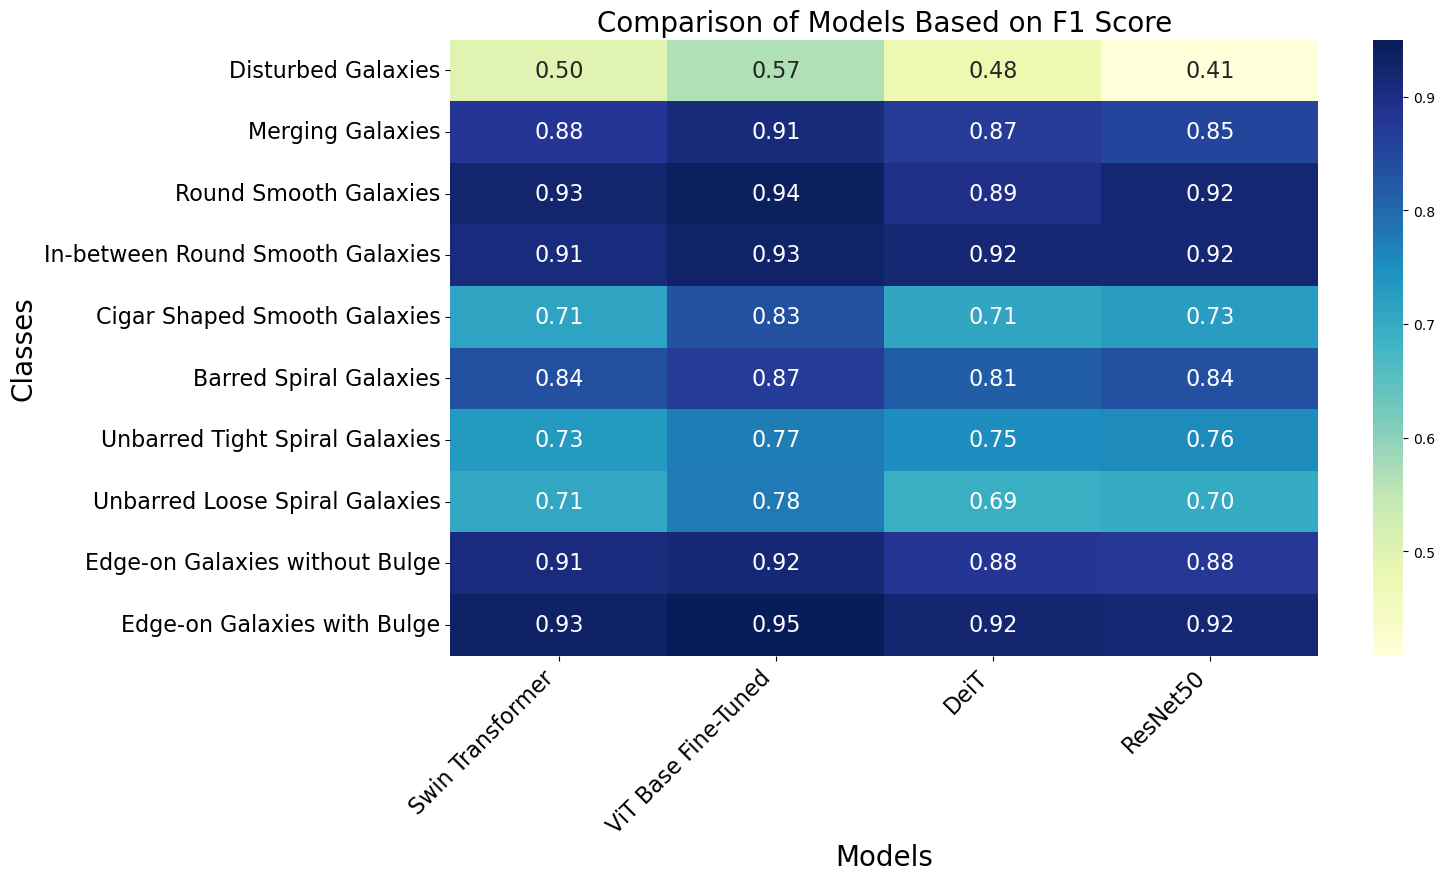

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


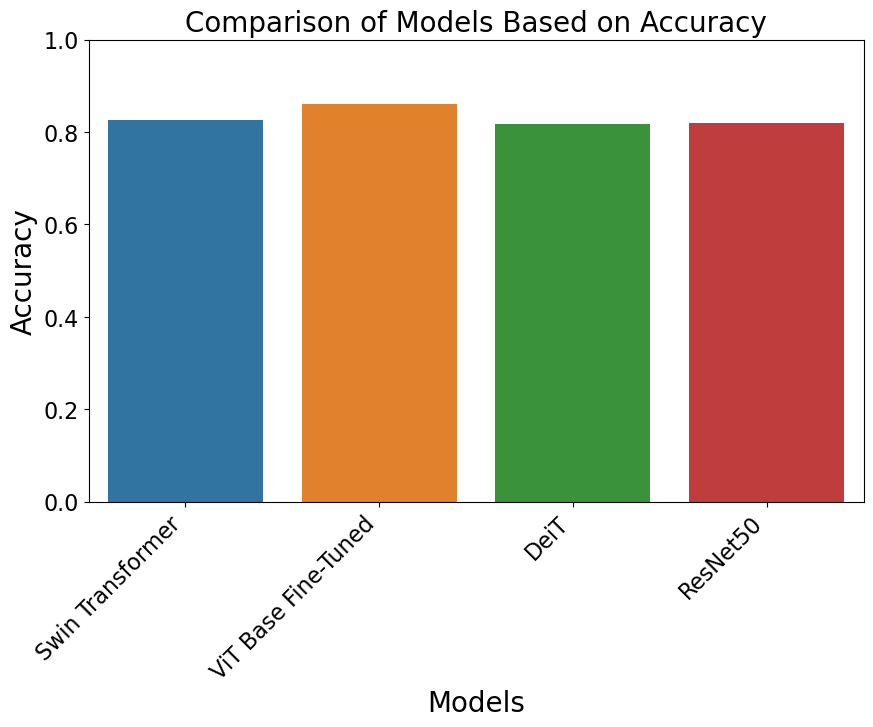

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to compute metrics for each class
def compute_class_metrics(all_labels, all_preds, class_names):
    precision = precision_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    recall = recall_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    f1 = f1_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    accuracy = accuracy_score(all_labels, all_preds)
    
    return precision, recall, f1, accuracy

# Function to plot metrics for all models
def plot_metrics(models, metric_name, metric_index, class_names):
    metric_data = {model_name: compute_class_metrics(labels, preds, class_names)[metric_index] 
                   for model_name, (labels, preds) in models.items()}

    metrics_df = pd.DataFrame(metric_data, index=class_names)

    plt.figure(figsize=(14, 8))
    sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.2f', annot_kws={"size": 16})
    plt.title(f'Comparison of Models Based on {metric_name}', fontsize=20)
    plt.ylabel('Classes', fontsize=20)
    plt.xlabel('Models', fontsize=20)
    plt.xticks(rotation=45, ha="right", fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

# Assuming `all_labels` and `all_preds` are defined for each model
models = {
    "Swin Transformer": (swin_all_labels, swin_all_preds),
    "ViT Base Fine-Tuned": (vit_all_labels, vit_all_preds),
    "DeiT": (deit_all_labels, deit_all_preds),
    "ResNet50": (resnet_all_labels, resnet_all_preds)
}

class_names = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]

# Plot metrics for all models
import pandas as pd

# Plot Precision
plot_metrics(models, "Precision", 0, class_names)

# Plot Recall
plot_metrics(models, "Recall", 1, class_names)

# Plot F1 Score
plot_metrics(models, "F1 Score", 2, class_names)

# Accuracy for each model
accuracies = {model_name: compute_class_metrics(labels, preds, class_names)[3] for model_name, (labels, preds) in models.items()}
accuracy_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])

# Plot Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Comparison of Models Based on Accuracy', fontsize=20)
plt.xlabel('Models', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 1)
plt.show()


# ROC/AUC Curve

## Swin Transformer Model Curve

In [37]:
def evaluate_model_with_probs(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Directly use outputs as they are logits
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Directly use outputs as they are logits
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_probs.extend(outputs.cpu().numpy())  # Directly use outputs as they are logits
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_labels, all_probs

# Evaluate the model
test_loss, test_acc, all_labels, all_probs = evaluate_model_with_probs(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Test Loss: 0.4495, Test Acc: 0.8560


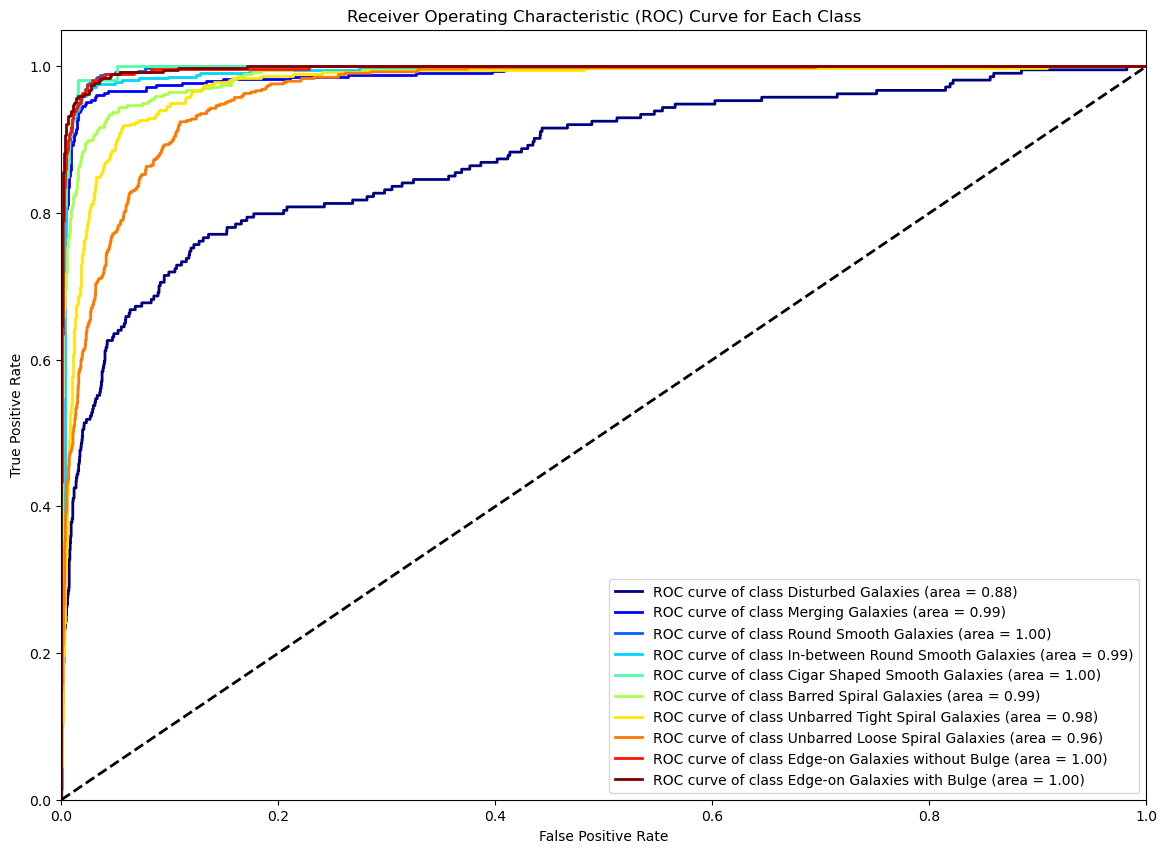

In [39]:
# Binarize the labels for multi-class ROC
class_names = [
    "Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", 
    "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies", 
    "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", 
    "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", 
    "Edge-on Galaxies with Bulge"
]
all_labels_binarized = label_binarize(all_labels, classes=range(10))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 10

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], [prob[i] for prob in all_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(14, 10))

colors = plt.cm.jet(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
